<a href="https://colab.research.google.com/github/welday007/Stock-Options/blob/main/Thinkorswim_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob

file_paths = glob.glob('20*.csv')
file_paths

['2024-01-26-StockAndOptionQuoteForSPY.csv',
 '2024-01-18-StockAndOptionQuoteForSPY.csv',
 '2024-01-11-StockAndOptionQuoteForSPY.csv',
 '2024-01-03-StockAndOptionQuoteForSPY.csv',
 '2023-12-12-StockAndOptionQuoteForSPY.csv',
 '2023-12-21-StockAndOptionQuoteForSPY.csv',
 '2023-12-11-StockAndOptionQuoteForSPY.csv',
 '2023-12-20-StockAndOptionQuoteForSPY.csv',
 '2024-01-24-StockAndOptionQuoteForSPY.csv',
 '2023-12-04-StockAndOptionQuoteForSPY.csv',
 '2024-01-30-StockAndOptionQuoteForSPY.csv',
 '2023-12-14-StockAndOptionQuoteForSPY.csv',
 '2023-12-26-StockAndOptionQuoteForSPY.csv',
 '2024-01-02-StockAndOptionQuoteForSPY.csv',
 '2024-01-05-StockAndOptionQuoteForSPY.csv',
 '2024-01-19-StockAndOptionQuoteForSPY.csv',
 '2024-01-10-StockAndOptionQuoteForSPY.csv',
 '2023-12-05-StockAndOptionQuoteForSPY.csv',
 '2023-12-06-StockAndOptionQuoteForSPY.csv',
 '2023-12-27-StockAndOptionQuoteForSPY.csv',
 '2023-12-08-StockAndOptionQuoteForSPY.csv',
 '2023-12-13-StockAndOptionQuoteForSPY.csv',
 '2024-01-

In [ ]:
import pandas as pd
import csv
import numpy as np

def extract_timestamp(file_path):
    """Extract the timestamp from the first line of the file."""
    with open(file_path, 'r') as file:
        first_line = file.readline().strip()
    timestamp = first_line.split('on ')[-1]
    return timestamp

def extract_underlying_symbol(file_path):
    """Extract the underlying symbol from the first line of the file."""
    with open(file_path, 'r') as file:
        first_line = file.readline().strip()
    parts = first_line.split()
    for_index = parts.index('for')
    on_index = parts.index('on')
    symbol = ' '.join(parts[for_index + 1:on_index])
    return symbol

def extract_underlying_price_change(file_path):
    """Extract price and change data from the file."""
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_line = lines[4].strip()
    data_parts = data_line.split(',')
    underlying_price = data_parts[0]
    net_change = data_parts[2].strip('+')
    open_price = data_parts[-3].strip('"')
    high_price = data_parts[-2]
    low_price = data_parts[-1]
    return underlying_price, net_change, open_price, high_price, low_price

def create_dataframe_from_files(file_paths):
    """Create a DataFrame from a list of file paths."""
    df_combined = pd.DataFrame()
    first_file = True  # Flag to check if it's the first file

    for file_path in file_paths:
        # Extract data from each file
        timestamp = extract_timestamp(file_path)
        symbol = extract_underlying_symbol(file_path)
        underlying_price, net_change, open_price, high_price, low_price = extract_underlying_price_change(file_path)

        # Create a temporary DataFrame for the underlying data
        underlying_data = pd.DataFrame({
            'Timestamp': [timestamp],
            'Underlying Symbol': [symbol],
            'Underlying Price': [underlying_price],
            'Net Change': [net_change],
            'Open': [open_price],
            'High': [high_price],
            'Low': [low_price]
        })

        if first_file:
            # Add the additional columns from row 12 only for the first file
            df_with_columns = add_columns_from_row_12(underlying_data, file_path)
            first_file = False
        else:
            # For subsequent files, use the same columns as the first file
            df_with_columns = pd.concat([pd.DataFrame(columns=df_combined.columns), underlying_data], ignore_index=True)

        # Add the option data from the rest of the file
        df_with_data = add_data(df_with_columns, file_path)

        # Combine this file's DataFrame with the main DataFrame
        df_combined = pd.concat([df_combined, df_with_data], ignore_index=True)

        print(f'{file_path} {len(df_with_data)}')

    return df_combined

def add_columns_from_row_12(df, file_path):
    """Add columns to the DataFrame based on the headers found in the 12th row of the file."""
    with open(file_path, 'r') as file:
        for _ in range(11):
            next(file)  # Skip the first 11 lines
        headers = next(file).strip().split(',')  # Read the 12th line headers

    for i, header in enumerate(headers):
        if i < 2 or i > 19:
            continue
        new_header = ('Call ' if i < 10 else 'Put ') + header if header not in ['Exp', 'Strike'] else header
        df[new_header] = ''  # Adding the new column with empty values

    return df

def process_value(val):
    """Process a string value to handle numbers with commas inside quotes correctly."""
    if '"' in val:  # Check if the value is within quotes
        cleaned_val = val.replace('"', '').replace(',', '')  # Remove quotes and commas
        return cleaned_val if cleaned_val.isdigit() else val  # Return as integer if it's a digit, otherwise return original
    return val

def add_data(df, file_path):
    new_rows = []  # List to accumulate new rows

    with open(file_path, 'r') as file:
        # Skip the first 12 lines
        for _ in range(12):
            next(file)

        consistent_data = df.iloc[0, :7].to_dict()  # Consistent data from the first row
        reader = csv.reader(file)  # Using csv.reader to handle commas within quotes correctly

        for data in reader:
            if len(data) < 3 or data[2] == df.columns[7]:
                continue  # Skip lines with insufficient data or matching headers

            # Creating a new row with consistent data for the first 7 columns
            new_row = {col: value for col, value in consistent_data.items()}

            # Mapping the data from file columns C to T to the DataFrame columns
            file_data_indices = range(2, 20)  # Indices for columns C to T in the file
            df_data_indices = range(7, 25)  # Corresponding indices in the DataFrame
            for file_index, df_index in zip(file_data_indices, df_data_indices):
                if file_index < len(data):
                    new_row[df.columns[df_index]] = process_value(data[file_index])
                else:
                    new_row[df.columns[df_index]] = ''  # Fill with empty string if data is missing

            new_rows.append(new_row)

    # Using pandas.concat instead of append
    df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
    # Remove rows where 'Strike' is empty or NaN
    df = df[df['Strike'].notna() & (df['Strike'] != '')]
        # Remove duplicate rows, keeping the first occurrence
    df = df.drop_duplicates(keep='first')

    return df

def Closest_Exp(given_date, unique_Exps, days_to_add):
    # Convert the given date to datetime64 format
    given_date = np.datetime64(given_date)

    # Initialize variables to keep track of the closest date and the minimum difference
    closest_date = None
    min_difference = None

    # Iterate through the list of unique dates
    for exp_date in unique_Exps:
        difference = np.abs((given_date + np.timedelta64(days_to_add, 'D')) - exp_date)

        # Check if this date is closer than the previous closest date
        if closest_date is None or difference < min_difference:
            closest_date = exp_date
            min_difference = difference

    return closest_date

In [ ]:
df = create_dataframe_from_files(file_paths)
#display(df[0:10])

# Remove rows with null values
df = df[df.isnull().notnull()]
df.replace('<empty>', 0, inplace=True)

df = df.drop(df[df['Strike'] == 'Strike'].index)

# Formatting columns
df['Call Cov Return'] = df['Call Cov Return'].str.replace('%', '')
df['Put Cov Return'] = df['Put Cov Return'].str.replace('%', '')

# Volume
df['Call Volume'] = df['Call Volume'].str.replace(',', '')
df['Put Volume'] = df['Put Volume'].str.replace(',', '')

df['Call Volume'] = pd.to_numeric(df['Call Volume'], errors='coerce')
df['Put Volume'] = pd.to_numeric(df['Put Volume'], errors='coerce')

# Replace any Volume value over 9 * 10^18 with 0
df['Call Volume'] = df['Call Volume'].apply(lambda x: 0 if x > 9 * 10**18 else x)
df['Put Volume'] = df['Put Volume'].apply(lambda x: 0 if x > 9 * 10**18 else x)

# Verify the replacement (optional, shows the updated stats as a check)
call_volume_stats_updated = df['Call Volume'].describe()
put_volume_stats_updated = df['Put Volume'].describe()

df['Call Open.Int'] = df['Call Open.Int'].str.replace(',', '')
df['Put Open.Int'] = df['Put Open.Int'].str.replace(',', '')
# Convert the Timestamp column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# Converting 'Exp' to datetime format with a specific format for the date
df['Exp'] = pd.to_datetime(df['Exp'], format='%d %b %y', errors='coerce')


columns_to_make_numeric = ['Underlying Price', 'Net Change',
       'Open', 'High', 'Low', 'Call Cov Return', 'Call Delta', 'Call Open.Int',
       'Call Volume', 'Call BID', 'Call ASK', 'Strike', 'Put BID',
       'Put ASK', 'Put Cov Return', 'Put Delta', 'Put Open.Int', 'Put Volume']

# Convert all object columns to numeric
for column in columns_to_make_numeric:
    df[column] = pd.to_numeric(df[column])

# Columns to remove
columns_to_remove = ['Call BX', 'Call AX', 'Put BX', 'Put AX']
# Removing the specified columns
df = df.drop(columns=columns_to_remove)

# Add necessary columns
df['Synthetic Long'] = df['Put BID'] - df['Call ASK']
df['Synthetic Long_Exit'] = df['Call BID'] - df['Put ASK']

2024-01-26-StockAndOptionQuoteForSPY.csv 4332
2024-01-18-StockAndOptionQuoteForSPY.csv 3949
2024-01-11-StockAndOptionQuoteForSPY.csv 4233
2024-01-03-StockAndOptionQuoteForSPY.csv 3895
2023-12-12-StockAndOptionQuoteForSPY.csv 4035
2023-12-21-StockAndOptionQuoteForSPY.csv 3771
2023-12-11-StockAndOptionQuoteForSPY.csv 4125
2023-12-20-StockAndOptionQuoteForSPY.csv 3798
2024-01-24-StockAndOptionQuoteForSPY.csv 3964
2023-12-04-StockAndOptionQuoteForSPY.csv 4209
2024-01-30-StockAndOptionQuoteForSPY.csv 4156
2023-12-14-StockAndOptionQuoteForSPY.csv 3902
2023-12-26-StockAndOptionQuoteForSPY.csv 4013
2024-01-02-StockAndOptionQuoteForSPY.csv 3976
2024-01-05-StockAndOptionQuoteForSPY.csv 3810
2024-01-19-StockAndOptionQuoteForSPY.csv 3904
2024-01-10-StockAndOptionQuoteForSPY.csv 4038
2023-12-05-StockAndOptionQuoteForSPY.csv 4121
2023-12-06-StockAndOptionQuoteForSPY.csv 4033
2023-12-27-StockAndOptionQuoteForSPY.csv 3923
2023-12-08-StockAndOptionQuoteForSPY.csv 3905
2023-12-13-StockAndOptionQuoteForS

In [ ]:
# prompt: show max call volume value

df['Put Volume'].max()


70187.0

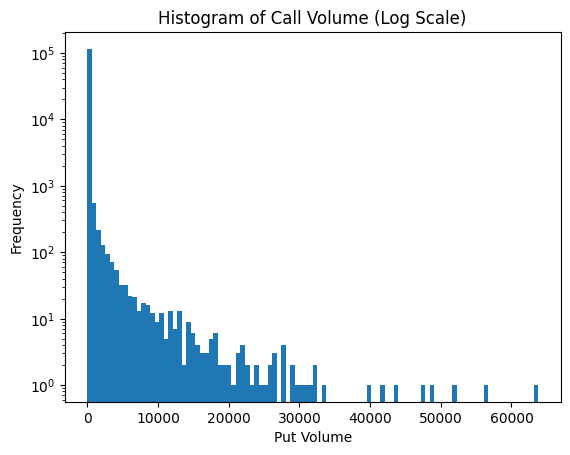

In [ ]:
# prompt: create histogram of call volume where volume > 0 and use log scale on x axis

import matplotlib.pyplot as plt

# Select data where Call Volume is greater than 0
call_volume_data = df[df['Put Volume'] >= 0]

# Create the histogram with logarithmic scale on x-axis
plt.hist(call_volume_data['Call Volume'], bins=100)
plt.yscale('log')

# Add title and axis labels
plt.title('Histogram of Call Volume (Log Scale)')
plt.xlabel('Put Volume')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [ ]:
df = df.sort_values(by=['Timestamp', 'Exp', 'Strike'])
df.to_csv('option prices.csv',index=False)
df

Timestamp Underlying Symbol  Underlying Price  Net Change  \
131989 2023-12-01 10:00:00               SPY          456.5700      0.1700   
131990 2023-12-01 10:00:00               SPY          456.5700      0.1700   
131991 2023-12-01 10:00:00               SPY          456.5700      0.1700   
131992 2023-12-01 10:00:00               SPY          456.5700      0.1700   
131993 2023-12-01 10:00:00               SPY          456.5700      0.1700   
...                    ...               ...               ...         ...   
96008  2024-01-31 10:00:00               SPY          487.7602     -3.1298   
96009  2024-01-31 10:00:00               SPY          487.7602     -3.1298   
96010  2024-01-31 10:00:00               SPY          487.7602     -3.1298   
96011  2024-01-31 10:00:00               SPY          487.7602     -3.1298   
96012  2024-01-31 10:00:00               SPY          487.7602     -3.1298   

          Open      High     Low  Call Cov Return  Call Delta  Call Open.Int  \
131989  455.77  456.6000  455.18           -40.85        1.00            1.0   
131990  455.77  456.6000  455.18           -41.26        1.00            0.0   
131991  455.77  456.6000  455.18           -41.26        1.00            1.0   
131992  455.77  456.6000  455.18           -40.03        1.00          154.0   
131993  455.77  456.6000  455.18           -40.44        1.00            0.0   
...        ...       ...     ...              ...         ...            ...   
96008   488.62  489.0813  487.53             0.23        0.07          128.0   
96009   488.62  489.0813  487.53             0.21        0.07            0.0   
96010   488.62  489.0813  487.53             0.20        0.06            0.0   
96011   488.62  489.0813  487.53             0.18        0.06            3.0   
96012   488.62  489.0813  487.53             0.15        0.05         1574.0   

        ...        Exp  Strike  Put BID Put ASK  Put Cov Return  Put Delta  \
131989  ... 2023-12-01   285.0     0.00    0.01            0.41       0.00   
131990  ... 2023-12-01   290.0     0.00    0.01            0.41       0.00   
131991  ... 2023-12-01   295.0     0.00    0.01            0.41       0.00   
131992  ... 2023-12-01   300.0     0.00    0.01            0.41       0.00   
131993  ... 2023-12-01   305.0     0.00    0.01            0.41       0.00   
...     ...        ...     ...      ...     ...             ...        ...   
96008   ... 2026-12-18   725.0   234.84  239.50            0.00      -1.00   
96009   ... 2026-12-18   730.0   240.00  244.50            0.00      -0.92   
96010   ... 2026-12-18   735.0   245.00  249.50            0.00      -0.92   
96011   ... 2026-12-18   740.0   250.00  254.50            0.00      -0.92   
96012   ... 2026-12-18   750.0   259.84  264.50            0.00      -1.00   

        Put Open.Int  Put Volume  Synthetic Long  Synthetic Long_Exit  
131989        1064.0         0.0         -171.18               170.95  
131990         726.0         0.0         -166.17               165.95  
131991         916.0         0.0         -161.17               160.95  
131992        1443.0         0.0         -156.42               155.73  
131993         993.0         0.0         -151.42               150.72  
...              ...         ...             ...                  ...  
96008          128.0         NaN          230.29              -237.59  
96009            0.0         NaN          235.74              -242.79  
96010            0.0         NaN          240.00              -249.00  
96011            0.0         NaN          246.24              -253.16  
96012            0.0         3.0          256.84              -263.20  

[167900 rows x 23 columns]

In [ ]:
# prompt: filter on call deltas between 0.01 and .99 and put deltas between -0.01 and -0.99 and call or put volume > 0 and not NaN

filtered_df = df[
    (df['Call Delta'] >= 0.01) & (df['Call Delta'] <= 0.99) &
    (df['Put Delta'] <= -0.01) & (df['Put Delta'] >= -0.99) &
    ((df['Call Volume'] > 0) | (df['Put Volume'] > 0)) &
    (df['Call Volume'].notna()) & (df['Put Volume'].notna())
]



In [ ]:
filtered_df

Timestamp Underlying Symbol  Underlying Price  Net Change  \
132088 2023-12-01 10:00:00               SPY          456.5700      0.1700   
132089 2023-12-01 10:00:00               SPY          456.5700      0.1700   
132090 2023-12-01 10:00:00               SPY          456.5700      0.1700   
132091 2023-12-01 10:00:00               SPY          456.5700      0.1700   
132092 2023-12-01 10:00:00               SPY          456.5700      0.1700   
...                    ...               ...               ...         ...   
95966  2024-01-31 10:00:00               SPY          487.7602     -3.1298   
95968  2024-01-31 10:00:00               SPY          487.7602     -3.1298   
95975  2024-01-31 10:00:00               SPY          487.7602     -3.1298   
95993  2024-01-31 10:00:00               SPY          487.7602     -3.1298   
96003  2024-01-31 10:00:00               SPY          487.7602     -3.1298   

          Open      High     Low  Call Cov Return  Call Delta  Call Open.Int  \
132088  455.77  456.6000  455.18            13.07        0.87        52307.0   
132089  455.77  456.6000  455.18            45.34        0.63        17700.0   
132090  455.77  456.6000  455.18            55.96        0.43        18679.0   
132091  455.77  456.6000  455.18            30.64        0.27        18671.0   
132092  455.77  456.6000  455.18            15.11        0.15        16745.0   
...        ...       ...     ...              ...         ...            ...   
95966   488.62  489.0813  487.53             4.32        0.54        78720.0   
95968   488.62  489.0813  487.53             3.93        0.52        46464.0   
95975   488.62  489.0813  487.53             2.74        0.43          896.0   
95993   488.62  489.0813  487.53             0.78        0.19         5504.0   
96003   488.62  489.0813  487.53             0.35        0.10         8064.0   

        ...        Exp  Strike  Put BID Put ASK  Put Cov Return  Put Delta  \
132088  ... 2023-12-01   455.0     0.62    0.63           51.06      -0.30   
132089  ... 2023-12-01   456.0     1.03    1.04           84.56      -0.42   
132090  ... 2023-12-01   457.0     1.58    1.59           94.36      -0.54   
132091  ... 2023-12-01   458.0     2.26    2.29           69.04      -0.64   
132092  ... 2023-12-01   459.0     3.05    3.12           53.51      -0.72   
...     ...        ...     ...      ...     ...             ...        ...   
95966   ... 2026-12-18   515.0    50.11   53.89            1.76      -0.49   
95968   ... 2026-12-18   525.0    54.59   58.30            1.37      -0.54   
95975   ... 2026-12-18   560.0    73.86   77.50            0.24      -0.77   
95993   ... 2026-12-18   650.0   160.00  164.50            0.00      -0.96   
96003   ... 2026-12-18   700.0   210.00  214.50            0.00      -0.94   

        Put Open.Int  Put Volume  Synthetic Long  Synthetic Long_Exit  
132088       36139.0      9726.0           -1.12                 1.09  
132089       16422.0      6486.0           -0.10                 0.08  
132090       11178.0       883.0            0.89                -0.91  
132091        4750.0       152.0            1.88                -1.92  
132092        2851.0        87.0            2.86                -2.94  
...              ...         ...             ...                  ...  
95966         2688.0         1.0          -12.80                 4.62  
95968         4992.0         1.0           -2.93                -5.30  
95975          131.0         1.0           33.26               -41.00  
95993            0.0         1.0          147.09              -155.34  
96003            0.0         2.0          204.45              -210.30  

[35831 rows x 23 columns]

In [ ]:
filtered_df.to_csv('filtered option prices.csv',index=False)


In [ ]:
unique_Exps = df['Exp'].unique()
unique_Strikes = df['Strike'].unique()
unique_Prices = df['Underlying Price'].unique()
unique_Timestamps = df['Timestamp'].unique()
unique_Timestamps = np.array(unique_Timestamps)
unique_Timestamps = np.sort(unique_Timestamps)
unique_Timestamps

array(['2023-12-01T10:00:00.000000000', '2023-12-04T10:00:00.000000000',
       '2023-12-05T10:00:00.000000000', '2023-12-06T10:00:00.000000000',
       '2023-12-07T10:00:00.000000000', '2023-12-08T10:00:00.000000000',
       '2023-12-11T10:00:00.000000000', '2023-12-12T10:00:00.000000000',
       '2023-12-13T10:00:00.000000000', '2023-12-14T10:00:00.000000000',
       '2023-12-15T10:00:00.000000000', '2023-12-18T10:00:00.000000000',
       '2023-12-19T10:00:00.000000000', '2023-12-20T10:00:00.000000000',
       '2023-12-21T10:00:00.000000000', '2023-12-22T10:00:00.000000000',
       '2023-12-26T10:00:00.000000000', '2023-12-27T10:00:00.000000000',
       '2023-12-28T10:00:00.000000000', '2023-12-29T10:00:00.000000000',
       '2024-01-01T10:00:00.000000000', '2024-01-02T10:00:00.000000000',
       '2024-01-03T10:00:00.000000000', '2024-01-04T10:00:00.000000000',
       '2024-01-05T10:00:00.000000000', '2024-01-08T10:00:00.000000000',
       '2024-01-09T10:00:00.000000000', '2024-01-10

In [ ]:
def analyze_synthetic_long(entry_date, exit_date, expiration_date):
    """
    Analyzes synthetic long positions for strikes 5 above and 5 below the ATM strike
    based on the given entry and exit dates, and expiration date.

    Parameters:
    - entry_date: The date to enter the position.
    - exit_date: The date to exit the position.
    - expiration_date: The expiration date of the options.

    Returns:
    - A DataFrame containing the analysis results for each strike.
    """
    import pandas as pd
    import numpy as np

    # Load the dataset (for this example, we assume the dataset 'df' is already loaded)

    # Filter the dataset for the specified period and expiration date
    period_data = df[(df['Timestamp'] >= entry_date) & (df['Timestamp'] <= exit_date)]

    # Determine the ATM strike
    spy_price_on_entry = period_data['Underlying Price'].iloc[0]
    spy_price_on_exit = period_data['Underlying Price'].iloc[-1]
    available_strikes = df[df['Exp'] == pd.to_datetime(expiration_date)]['Strike']
    closest_strike_to_spy = available_strikes.iloc[(available_strikes - spy_price_on_entry).abs().argsort()[:1]].iloc[0]

    # Define the range of strikes 5 above and 5 below the ATM
    strike_range = range(int(closest_strike_to_spy) - 1, int(closest_strike_to_spy) + 4)

    results = []

    for strike in strike_range:
        strike_data = df[(df['Strike'] == strike) & (df['Exp'] == pd.to_datetime(expiration_date))]
        strike_period_data = strike_data[(strike_data['Timestamp'] >= entry_date) & (strike_data['Timestamp'] <= exit_date)]

        if not strike_period_data.empty:
            entry = strike_period_data.iloc[0]
            exit = strike_period_data.iloc[-1]

            entry_call_ask = entry['Call ASK']
            entry_put_bid = entry['Put BID']
            exit_call_bid = exit['Call BID']
            exit_put_ask = exit['Put ASK']
            entry_delta = entry['Call Delta']
            exit_delta = exit['Call Delta']

            synthetic_long_entry_price = entry_call_ask - entry_put_bid
            synthetic_long_exit_price = exit_call_bid - exit_put_ask
            profit = synthetic_long_exit_price - synthetic_long_entry_price

            results.append({
                "Strike": strike,
                "Entry Date Call Ask": entry_call_ask,
                "Entry Date Put Bid": entry_put_bid,
                "Entry Date Delta": entry_delta,
                "Exit Date Call Bid": exit_call_bid,
                "Exit Date Put Ask": exit_put_ask,
                "Exit Date Delta": exit_delta,
                "Profit": profit
            })

    results_df = pd.DataFrame(results)
    if not results_df.empty:
        # Calculate SPY's performance for comparison
        spy_profit = spy_price_on_exit - spy_price_on_entry
        results_df['% SPY'] = results_df['Profit'].apply(lambda x: (x / spy_profit) * 100)
        results_df['Option Expiration'] = expiration_date

    return spy_price_on_entry, spy_price_on_exit, spy_profit, results_df

# Note: This function is a template and requires the 'df' DataFrame to be defined in the scope where it's executed.
# Replace 'df' with the actual DataFrame variable containing your dataset when implementing this function.


In [ ]:
def plot_Profit_vs_Delta(df):  # Plot profit vs. Entry Date Delta
  plt.plot(df['Entry Date Delta'], df['Profit'])
  plt.xlabel('Entry Date Delta')
  plt.ylabel('Profit')
  plt.title('Profit vs. Entry Date Delta')
  plt.show()

def plot_PctSPY_vs_Delta(df):  # Plot % SPY vs. Entry Date Delta
  plt.plot(df['Entry Date Delta'], df['% SPY'])
  plt.xlabel('Entry Date Delta')
  plt.ylabel('% SPY')
  plt.title('% SPY vs. Entry Date Delta')
  plt.show()

In [ ]:
import matplotlib.pyplot as plt

456.57 - 458.03 = 1.4599999999999795


Strike  Entry Date Call Ask  Entry Date Put Bid  Entry Date Delta  \
0     456                 3.16                2.59              0.57   
1     457                 2.63                3.07              0.51   
2     458                 2.17                3.62              0.45   
3     459                 1.76                4.22              0.39   
4     460                 1.40                4.85              0.33   

   Exit Date Call Bid  Exit Date Put Ask  Exit Date Delta  Profit       % SPY  \
0                3.39               1.12             0.67    1.70  116.438356   
1                2.75               1.47             0.60    1.72  117.808219   
2                2.18               1.90             0.52    1.73  118.493151   
3                1.69               2.40             0.44    1.75  119.863014   
4                1.28               2.99             0.37    1.74  119.178082   

  Option Expiration  
0        2023-12-08  
1        2023-12-08  
2        2023-12-08  
3        2023-12-08  
4        2023-12-08

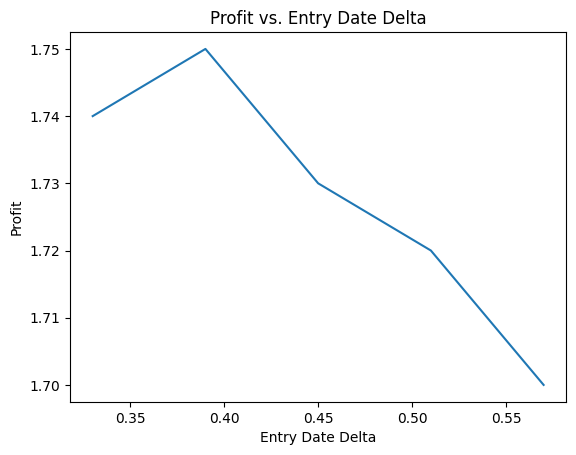

In [ ]:
entry_date = '2023-12-01'
exit_date = '2023-12-07'
expiration_date = '2023-12-08'
spy_price_on_entry, spy_price_on_exit, spy_profit, results_df = analyze_synthetic_long(entry_date, exit_date, expiration_date)
print (f'{spy_price_on_entry} - {spy_price_on_exit} = {spy_profit}')
display(results_df)
plot_Profit_vs_Delta(results_df)

2023-12-01T10:00:00.000000000 - 2023-12-07T10:00:00.000000000 Exp 2023-12-08T00:00:00.000000000
456.57 - 456.46 = -0.11000000000001364


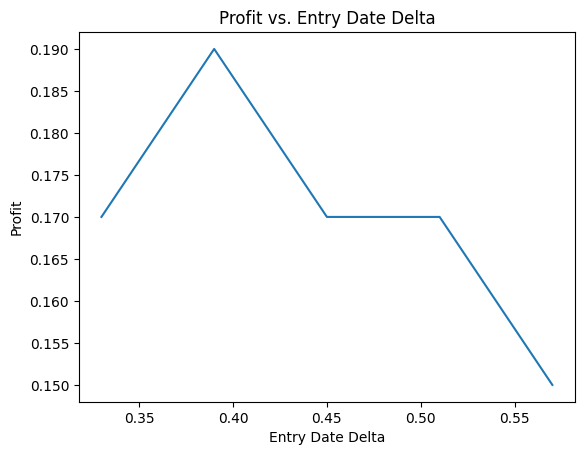

2023-12-01T10:00:00.000000000 - 2023-12-07T10:00:00.000000000 Exp 2023-12-11T00:00:00.000000000
456.57 - 456.46 = -0.11000000000001364


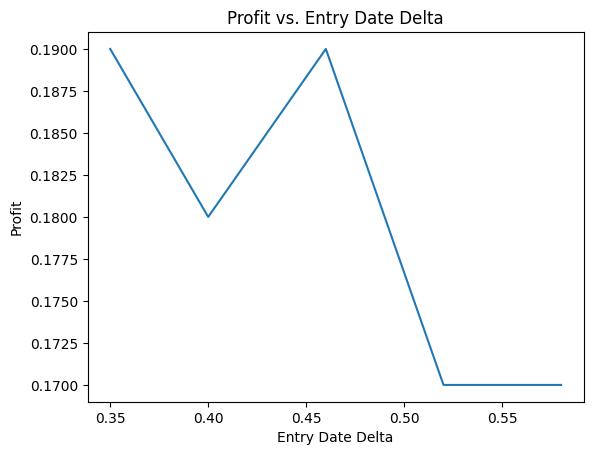

2023-12-01T10:00:00.000000000 - 2023-12-07T10:00:00.000000000 Exp 2023-12-12T00:00:00.000000000
456.57 - 456.46 = -0.11000000000001364


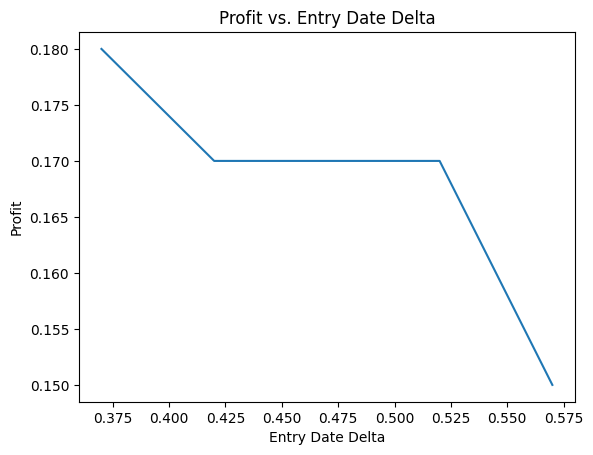

2023-12-04T10:00:00.000000000 - 2023-12-11T10:00:00.000000000 Exp 2023-12-12T00:00:00.000000000
456.01 - 460.46 = 4.449999999999989


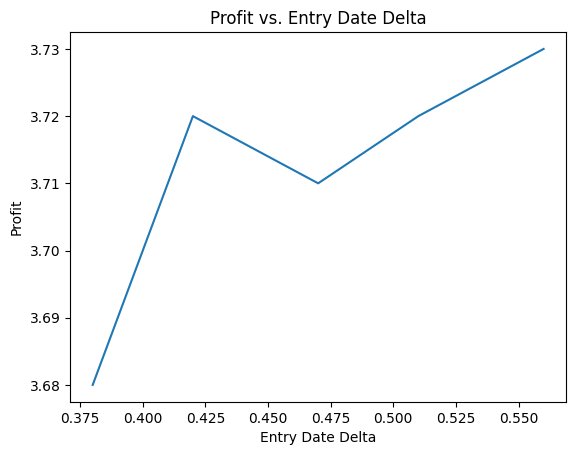

2023-12-04T10:00:00.000000000 - 2023-12-11T10:00:00.000000000 Exp 2023-12-13T00:00:00.000000000
456.01 - 460.46 = 4.449999999999989


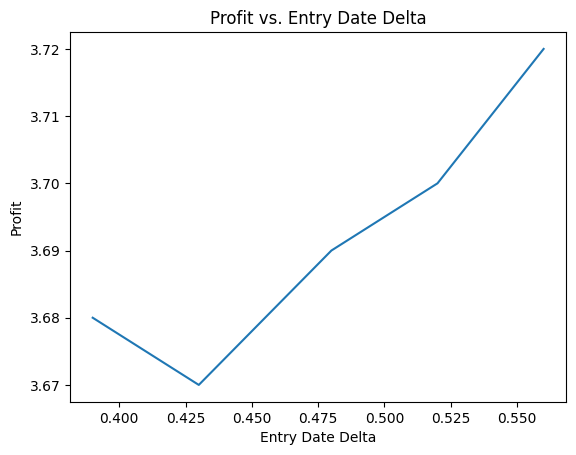

2023-12-04T10:00:00.000000000 - 2023-12-11T10:00:00.000000000 Exp 2023-12-14T00:00:00.000000000
456.01 - 460.46 = 4.449999999999989


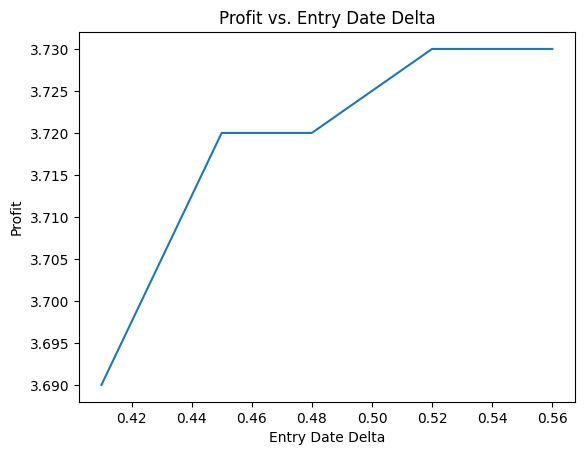

2023-12-05T10:00:00.000000000 - 2023-12-11T10:00:00.000000000 Exp 2023-12-12T00:00:00.000000000
455.62 - 460.46 = 4.839999999999975


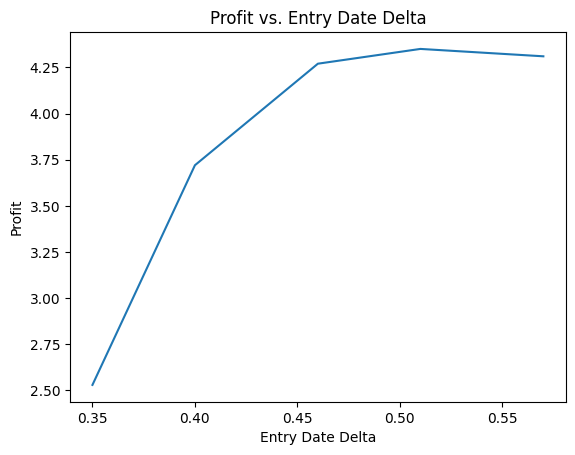

2023-12-05T10:00:00.000000000 - 2023-12-11T10:00:00.000000000 Exp 2023-12-13T00:00:00.000000000
455.62 - 460.46 = 4.839999999999975


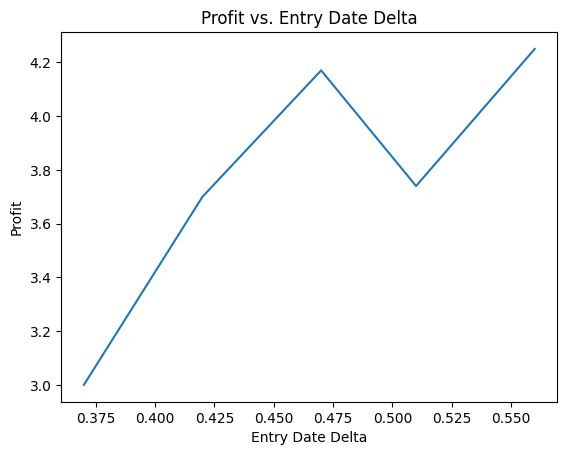

2023-12-05T10:00:00.000000000 - 2023-12-11T10:00:00.000000000 Exp 2023-12-14T00:00:00.000000000
455.62 - 460.46 = 4.839999999999975


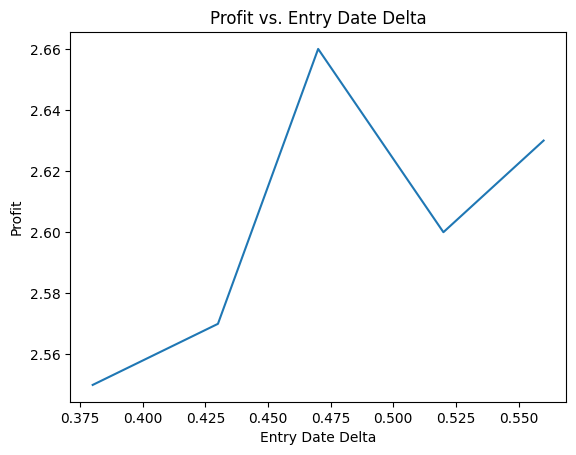

2023-12-06T10:00:00.000000000 - 2023-12-12T10:00:00.000000000 Exp 2023-12-13T00:00:00.000000000
458.03 - 461.51 = 3.480000000000018


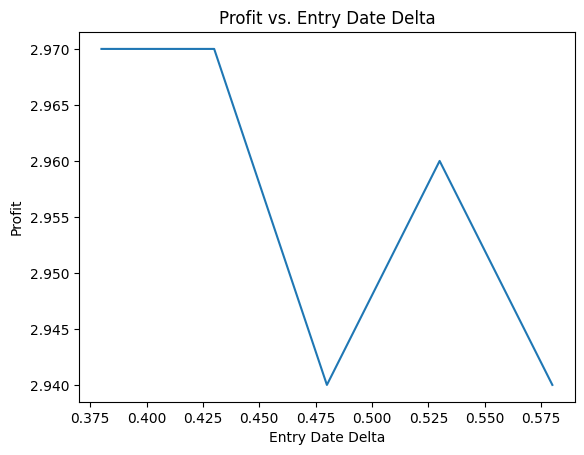

2023-12-06T10:00:00.000000000 - 2023-12-12T10:00:00.000000000 Exp 2023-12-14T00:00:00.000000000
458.03 - 461.51 = 3.480000000000018


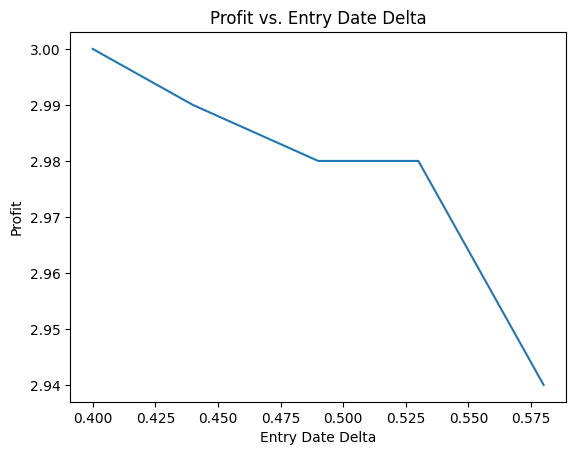

2023-12-06T10:00:00.000000000 - 2023-12-12T10:00:00.000000000 Exp 2023-12-15T00:00:00.000000000
458.03 - 461.51 = 3.480000000000018


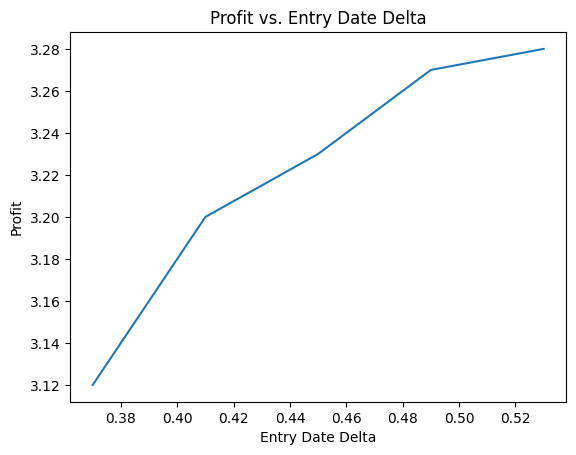

2023-12-07T10:00:00.000000000 - 2023-12-13T10:00:00.000000000 Exp 2023-12-14T00:00:00.000000000
456.46 - 464.47 = 8.010000000000048


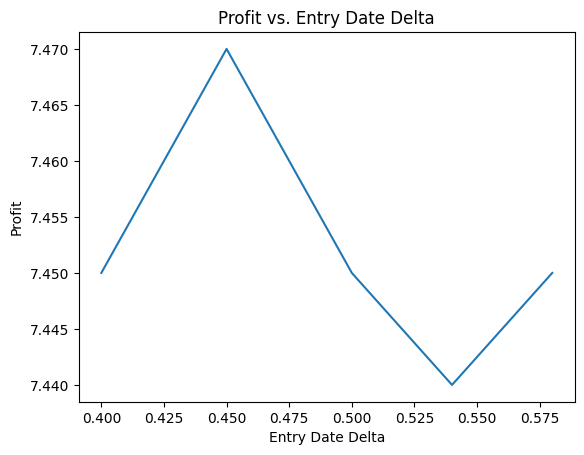

2023-12-07T10:00:00.000000000 - 2023-12-13T10:00:00.000000000 Exp 2023-12-15T00:00:00.000000000
456.46 - 464.47 = 8.010000000000048


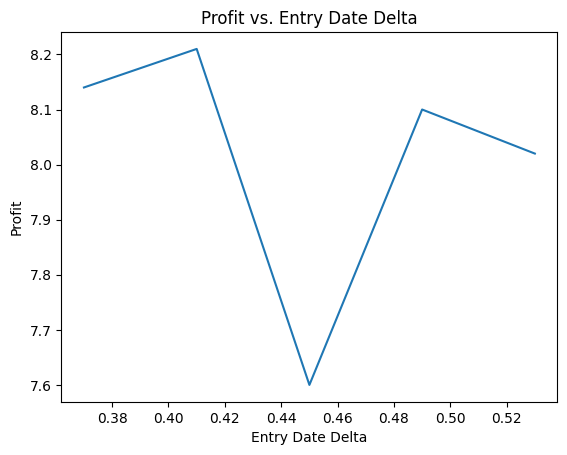

2023-12-07T10:00:00.000000000 - 2023-12-13T10:00:00.000000000 Exp 2023-12-22T00:00:00.000000000
456.46 - 464.47 = 8.010000000000048


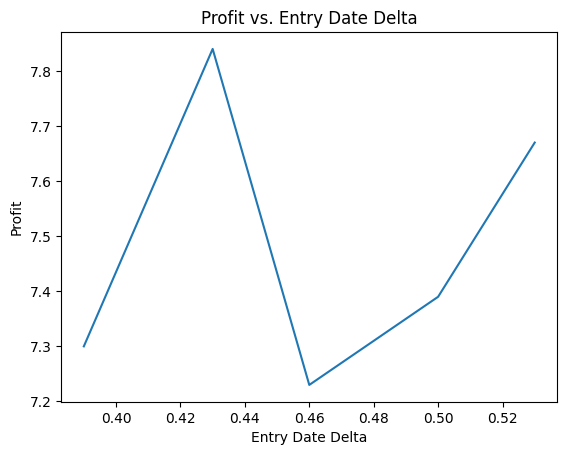

2023-12-08T10:00:00.000000000 - 2023-12-14T10:00:00.000000000 Exp 2023-12-15T00:00:00.000000000
458.74 - 473.15 = 14.409999999999968


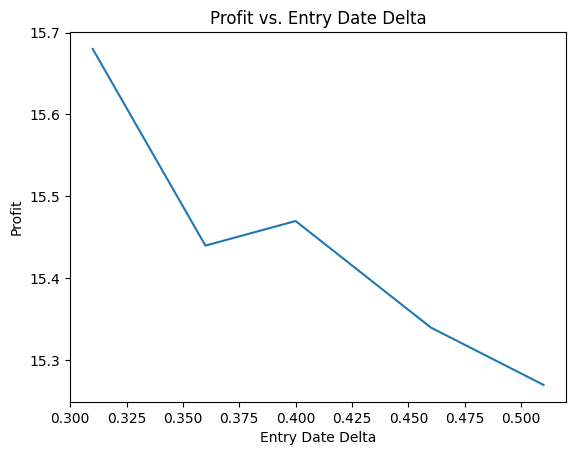

2023-12-08T10:00:00.000000000 - 2023-12-14T10:00:00.000000000 Exp 2023-12-22T00:00:00.000000000
458.74 - 473.15 = 14.409999999999968


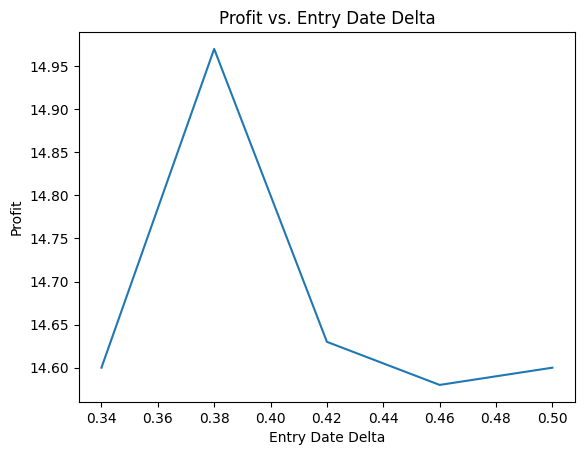

2023-12-08T10:00:00.000000000 - 2023-12-14T10:00:00.000000000 Exp 2023-12-29T00:00:00.000000000
458.74 - 473.15 = 14.409999999999968


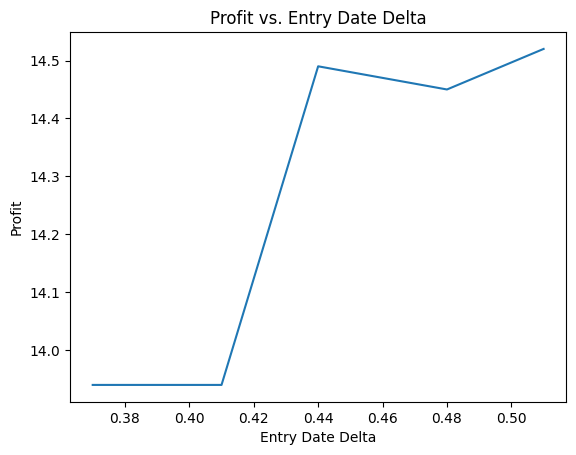

2023-12-11T10:00:00.000000000 - 2023-12-18T10:00:00.000000000 Exp 2023-12-22T00:00:00.000000000
460.46 - 471.41 = 10.950000000000045


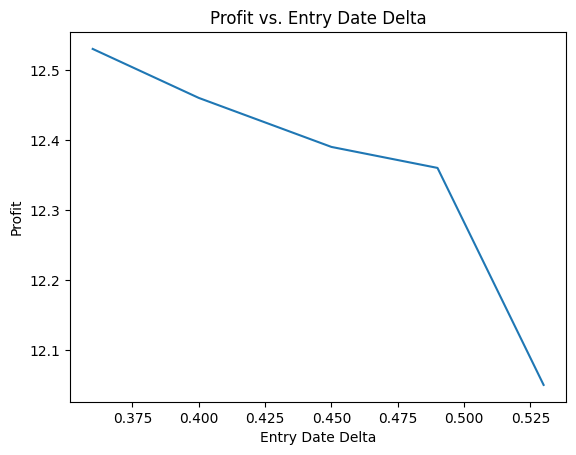

2023-12-11T10:00:00.000000000 - 2023-12-18T10:00:00.000000000 Exp 2023-12-29T00:00:00.000000000
460.46 - 471.41 = 10.950000000000045


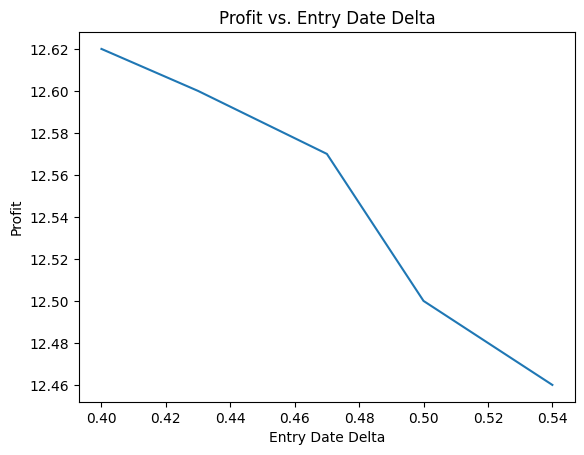

2023-12-11T10:00:00.000000000 - 2023-12-18T10:00:00.000000000 Exp 2024-01-05T00:00:00.000000000
460.46 - 471.41 = 10.950000000000045


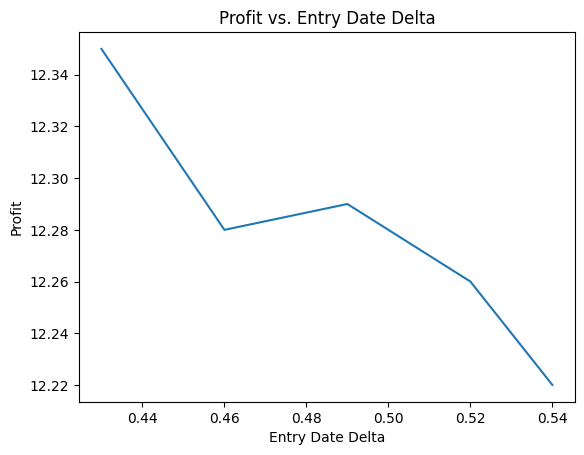

2023-12-12T10:00:00.000000000 - 2023-12-18T10:00:00.000000000 Exp 2023-12-22T00:00:00.000000000
461.51 - 471.41 = 9.900000000000034


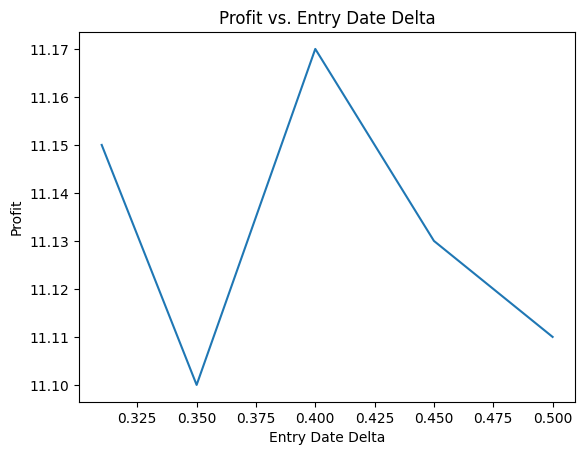

2023-12-12T10:00:00.000000000 - 2023-12-18T10:00:00.000000000 Exp 2023-12-29T00:00:00.000000000
461.51 - 471.41 = 9.900000000000034


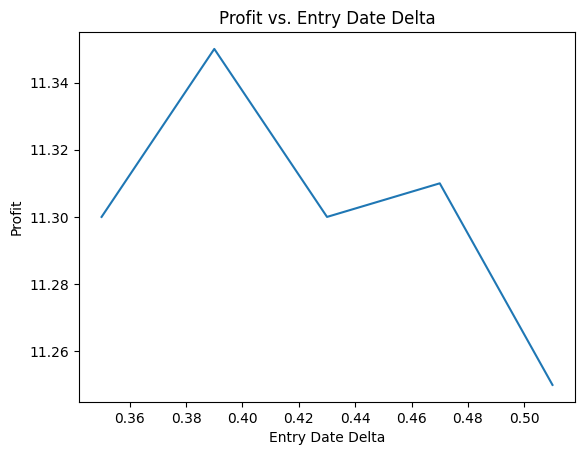

2023-12-12T10:00:00.000000000 - 2023-12-18T10:00:00.000000000 Exp 2024-01-05T00:00:00.000000000
461.51 - 471.41 = 9.900000000000034


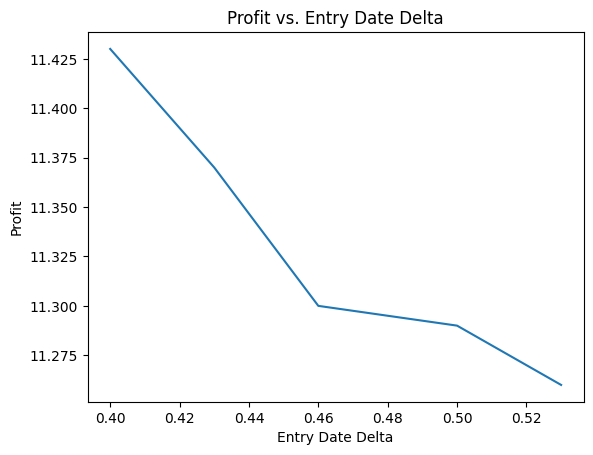

2023-12-13T10:00:00.000000000 - 2023-12-19T10:00:00.000000000 Exp 2023-12-22T00:00:00.000000000
464.47 - 473.5 = 9.029999999999973


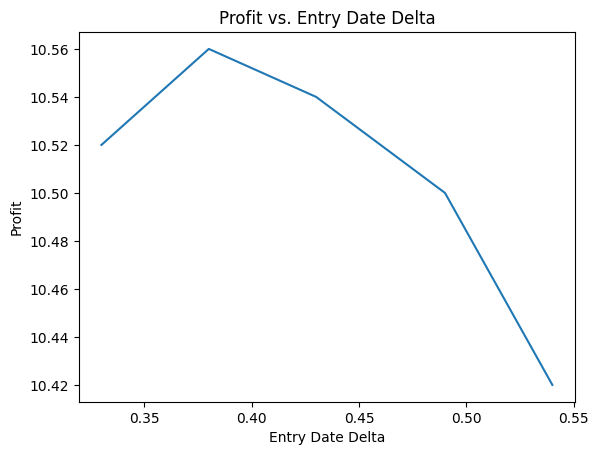

2023-12-13T10:00:00.000000000 - 2023-12-19T10:00:00.000000000 Exp 2023-12-29T00:00:00.000000000
464.47 - 473.5 = 9.029999999999973


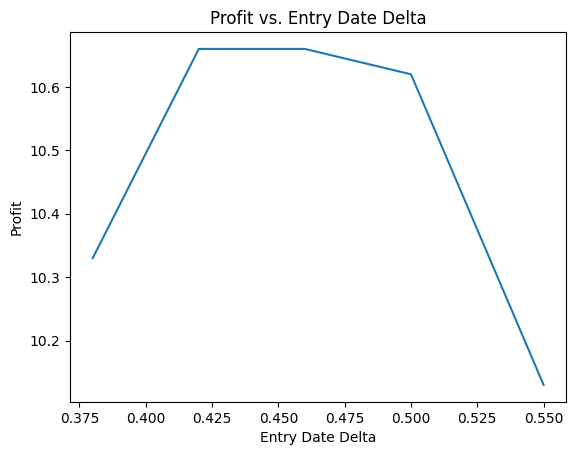

2023-12-13T10:00:00.000000000 - 2023-12-19T10:00:00.000000000 Exp 2024-01-05T00:00:00.000000000
464.47 - 473.5 = 9.029999999999973


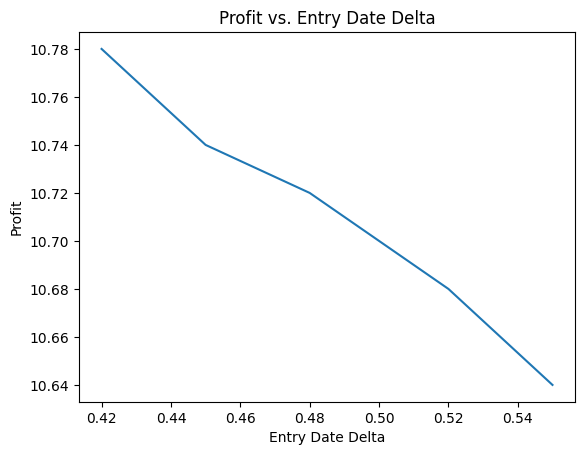

2023-12-14T10:00:00.000000000 - 2023-12-20T10:00:00.000000000 Exp 2023-12-22T00:00:00.000000000
473.15 - 474.63 = 1.4800000000000182


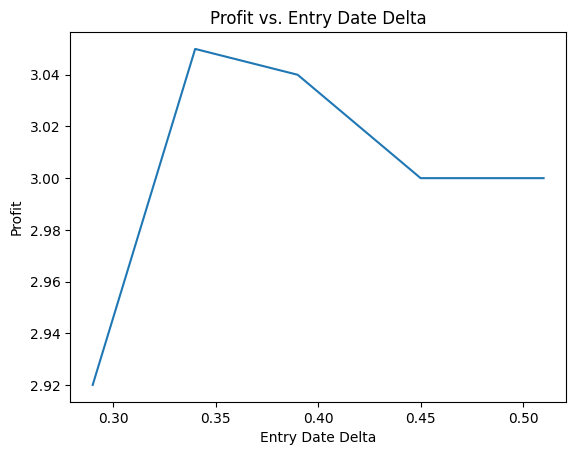

2023-12-14T10:00:00.000000000 - 2023-12-20T10:00:00.000000000 Exp 2023-12-29T00:00:00.000000000
473.15 - 474.63 = 1.4800000000000182


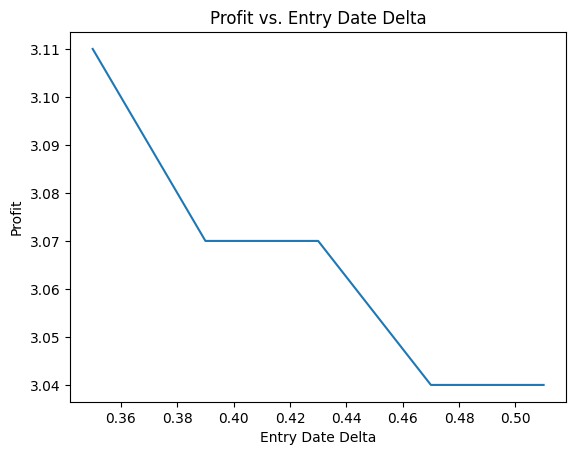

2023-12-14T10:00:00.000000000 - 2023-12-20T10:00:00.000000000 Exp 2024-01-05T00:00:00.000000000
473.15 - 474.63 = 1.4800000000000182


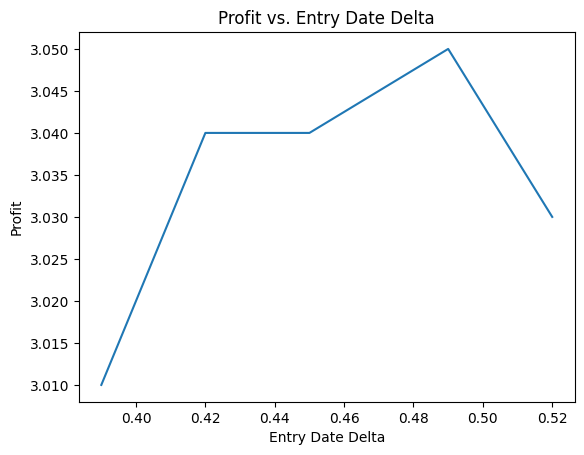

2023-12-15T10:00:00.000000000 - 2023-12-21T10:00:00.000000000 Exp 2023-12-22T00:00:00.000000000
469.27 - 471.4 = 2.1299999999999955


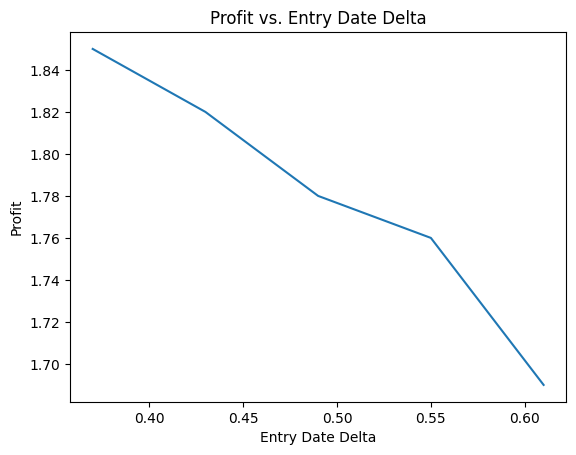

2023-12-15T10:00:00.000000000 - 2023-12-21T10:00:00.000000000 Exp 2023-12-29T00:00:00.000000000
469.27 - 471.4 = 2.1299999999999955


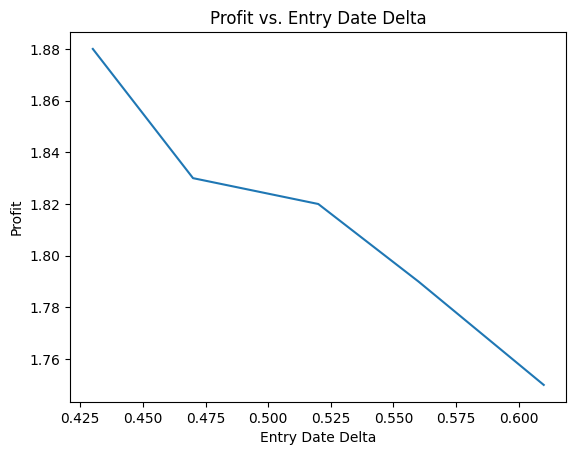

2023-12-15T10:00:00.000000000 - 2023-12-21T10:00:00.000000000 Exp 2024-01-05T00:00:00.000000000
469.27 - 471.4 = 2.1299999999999955


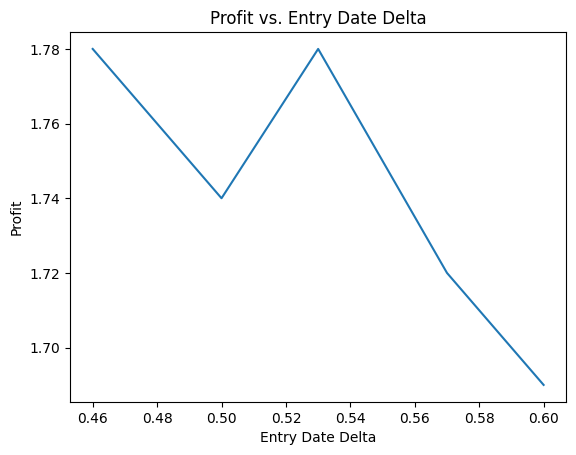

2023-12-18T10:00:00.000000000 - 2023-12-22T10:00:00.000000000 Exp 2023-12-29T00:00:00.000000000
471.41 - 475.06 = 3.6499999999999773


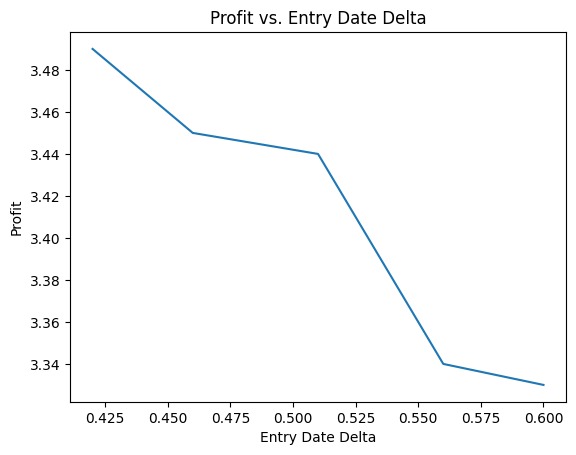

2023-12-18T10:00:00.000000000 - 2023-12-22T10:00:00.000000000 Exp 2024-01-05T00:00:00.000000000
471.41 - 475.06 = 3.6499999999999773


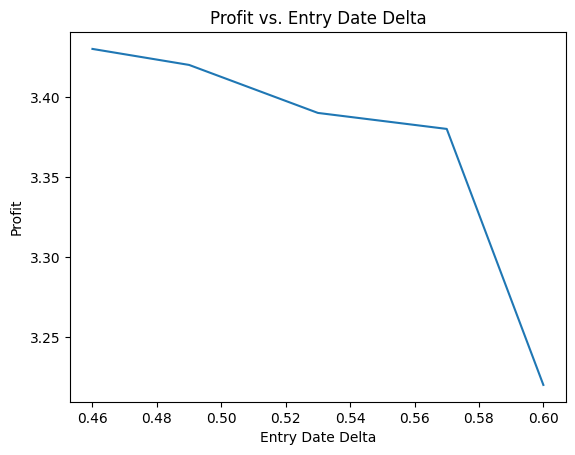

2023-12-18T10:00:00.000000000 - 2023-12-22T10:00:00.000000000 Exp 2024-01-12T00:00:00.000000000
471.41 - 475.06 = 3.6499999999999773


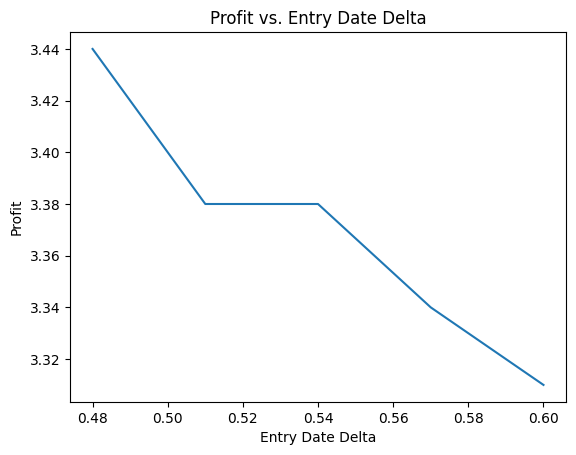

2023-12-19T10:00:00.000000000 - 2023-12-26T10:00:00.000000000 Exp 2023-12-29T00:00:00.000000000
473.5 - 474.675 = 1.1750000000000114


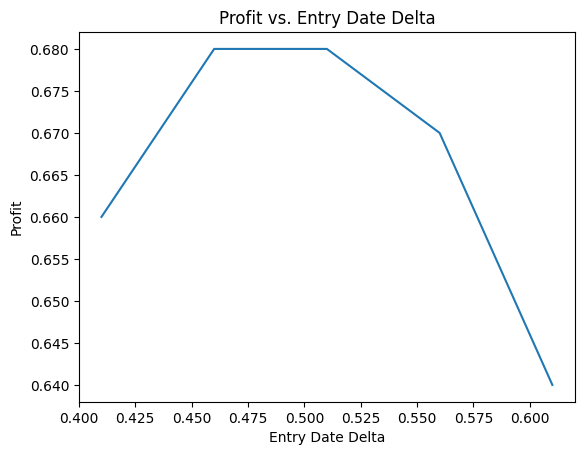

2023-12-19T10:00:00.000000000 - 2023-12-26T10:00:00.000000000 Exp 2024-01-05T00:00:00.000000000
473.5 - 474.675 = 1.1750000000000114


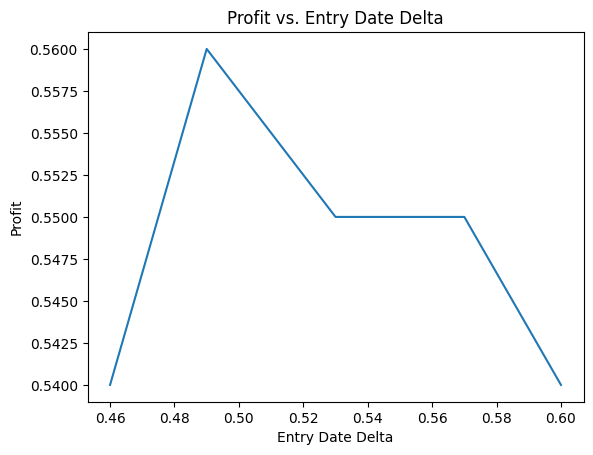

2023-12-19T10:00:00.000000000 - 2023-12-26T10:00:00.000000000 Exp 2024-01-12T00:00:00.000000000
473.5 - 474.675 = 1.1750000000000114


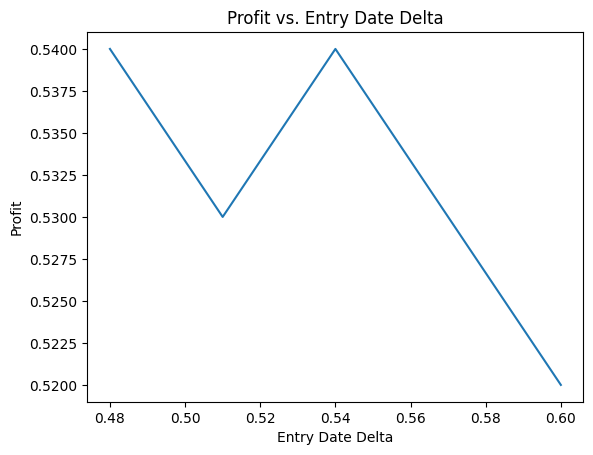

2023-12-20T10:00:00.000000000 - 2023-12-26T10:00:00.000000000 Exp 2023-12-29T00:00:00.000000000
474.63 - 474.675 = 0.045000000000015916


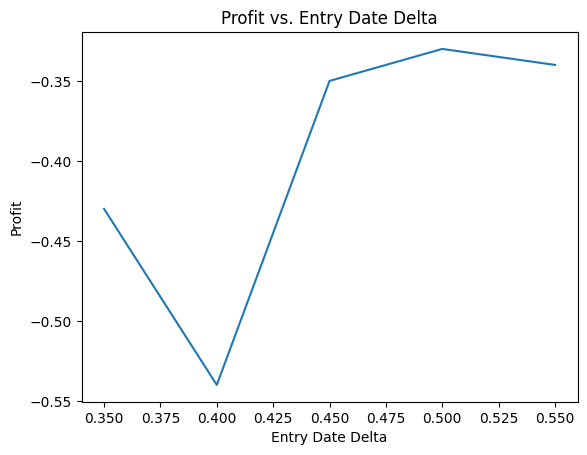

2023-12-20T10:00:00.000000000 - 2023-12-26T10:00:00.000000000 Exp 2024-01-05T00:00:00.000000000
474.63 - 474.675 = 0.045000000000015916


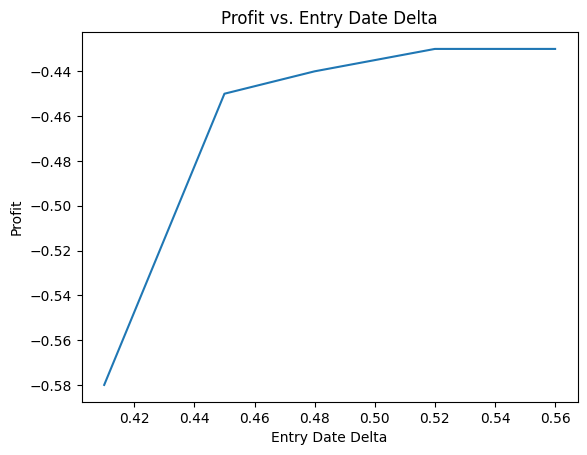

2023-12-20T10:00:00.000000000 - 2023-12-26T10:00:00.000000000 Exp 2024-01-12T00:00:00.000000000
474.63 - 474.675 = 0.045000000000015916


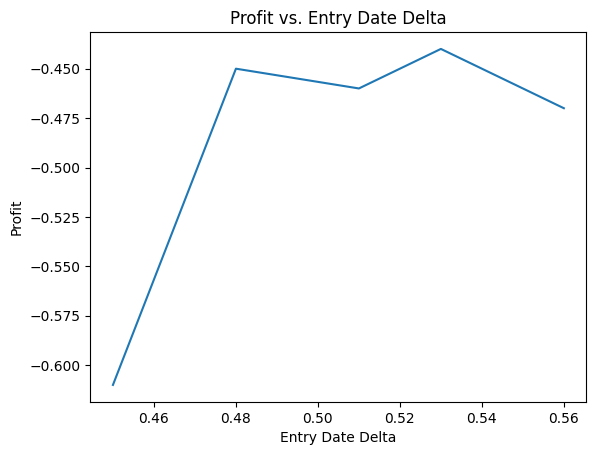

2023-12-21T10:00:00.000000000 - 2023-12-27T10:00:00.000000000 Exp 2023-12-29T00:00:00.000000000
471.4 - 476.02 = 4.6200000000000045


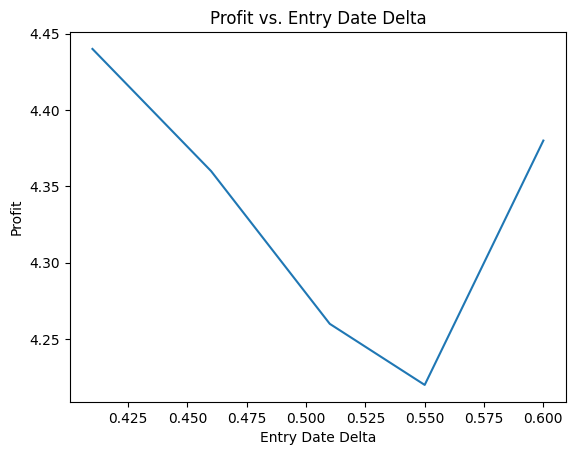

2023-12-21T10:00:00.000000000 - 2023-12-27T10:00:00.000000000 Exp 2024-01-05T00:00:00.000000000
471.4 - 476.02 = 4.6200000000000045


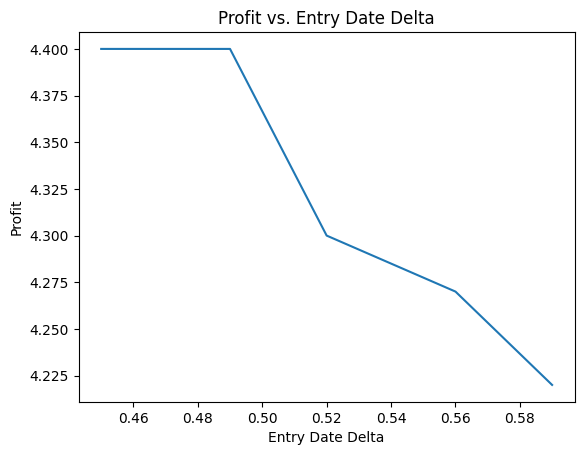

2023-12-21T10:00:00.000000000 - 2023-12-27T10:00:00.000000000 Exp 2024-01-12T00:00:00.000000000
471.4 - 476.02 = 4.6200000000000045


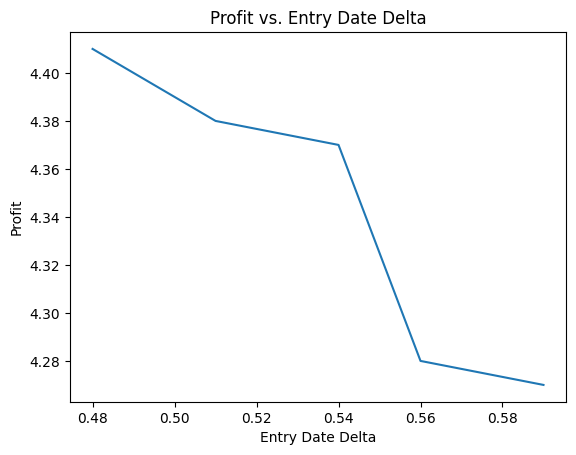

2023-12-22T10:00:00.000000000 - 2023-12-28T10:00:00.000000000 Exp 2023-12-29T00:00:00.000000000
475.06 - 477.1794 = 2.1193999999999846


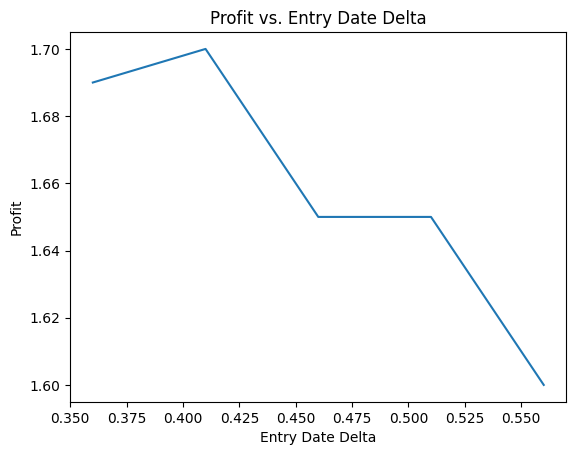

2023-12-22T10:00:00.000000000 - 2023-12-28T10:00:00.000000000 Exp 2024-01-05T00:00:00.000000000
475.06 - 477.1794 = 2.1193999999999846


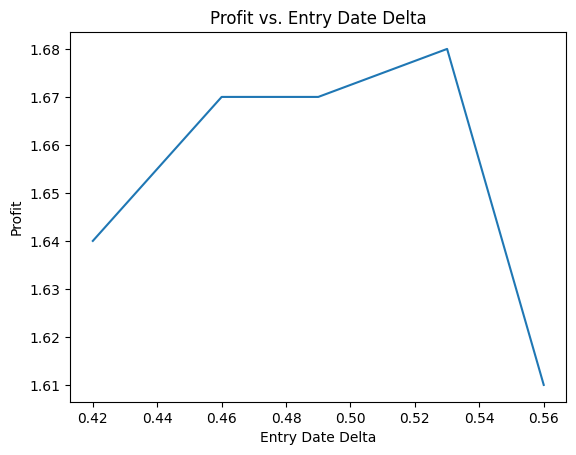

2023-12-22T10:00:00.000000000 - 2023-12-28T10:00:00.000000000 Exp 2024-01-12T00:00:00.000000000
475.06 - 477.1794 = 2.1193999999999846


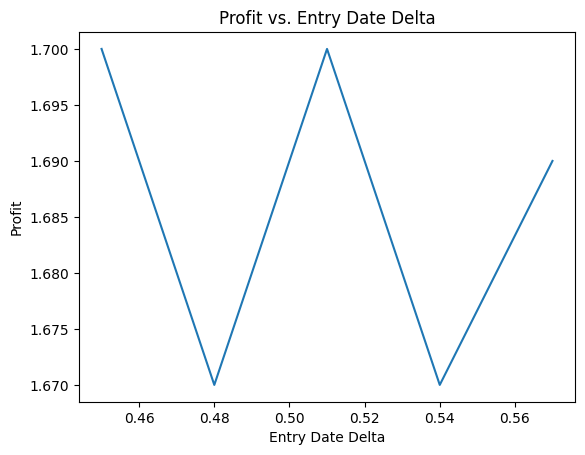

2023-12-26T10:00:00.000000000 - 2024-01-01T10:00:00.000000000 Exp 2024-01-05T00:00:00.000000000
474.675 - 475.31 = 0.6349999999999909


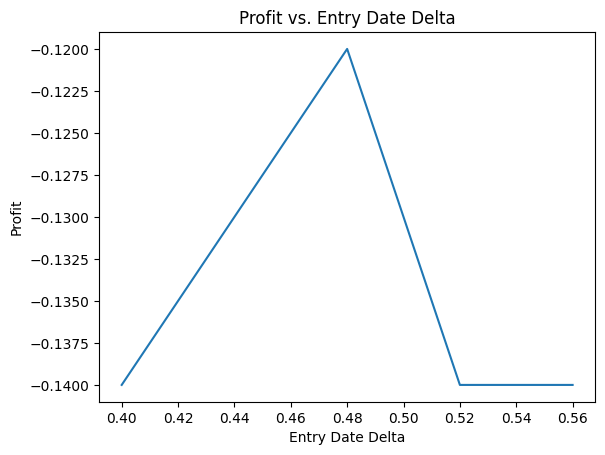

2023-12-26T10:00:00.000000000 - 2024-01-01T10:00:00.000000000 Exp 2024-01-12T00:00:00.000000000
474.675 - 475.31 = 0.6349999999999909


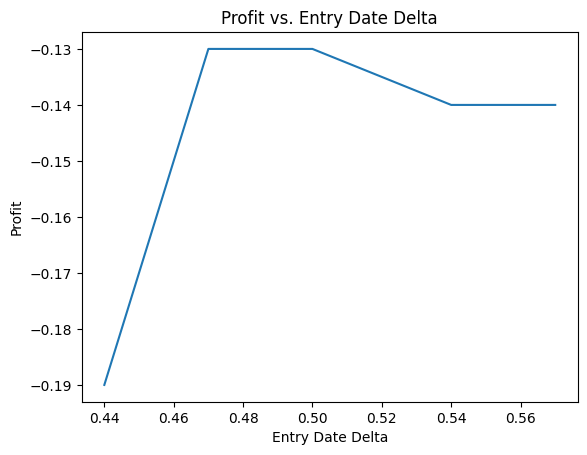

2023-12-26T10:00:00.000000000 - 2024-01-01T10:00:00.000000000 Exp 2024-01-19T00:00:00.000000000
474.675 - 475.31 = 0.6349999999999909


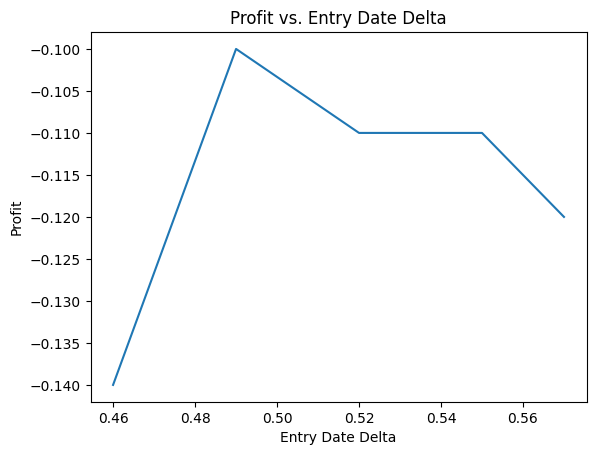

2023-12-27T10:00:00.000000000 - 2024-01-02T10:00:00.000000000 Exp 2024-01-05T00:00:00.000000000
476.02 - 472.16 = -3.859999999999957


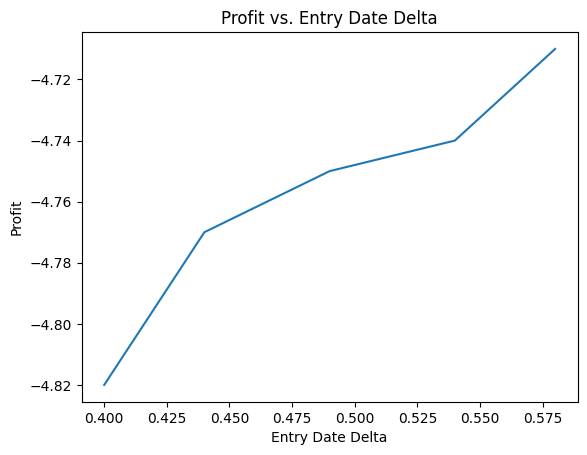

2023-12-27T10:00:00.000000000 - 2024-01-02T10:00:00.000000000 Exp 2024-01-12T00:00:00.000000000
476.02 - 472.16 = -3.859999999999957


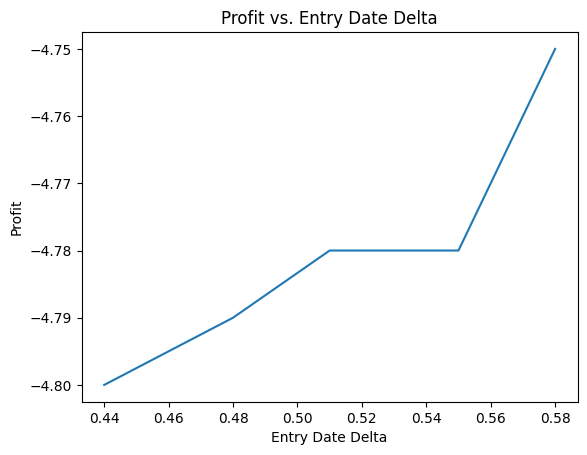

2023-12-27T10:00:00.000000000 - 2024-01-02T10:00:00.000000000 Exp 2024-01-19T00:00:00.000000000
476.02 - 472.16 = -3.859999999999957


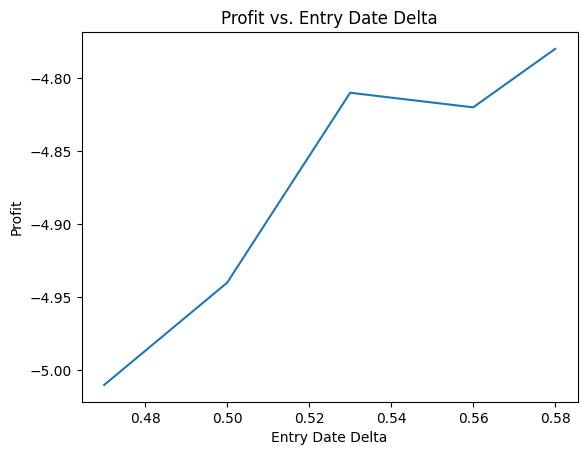

2023-12-28T10:00:00.000000000 - 2024-01-03T10:00:00.000000000 Exp 2024-01-05T00:00:00.000000000
477.1794 - 469.83 = -7.349400000000003


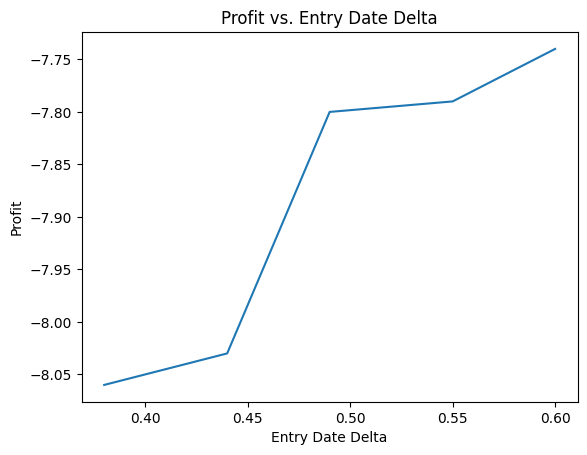

2023-12-28T10:00:00.000000000 - 2024-01-03T10:00:00.000000000 Exp 2024-01-12T00:00:00.000000000
477.1794 - 469.83 = -7.349400000000003


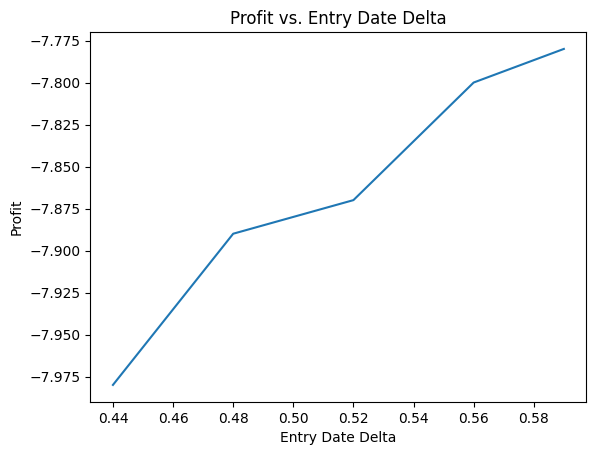

2023-12-28T10:00:00.000000000 - 2024-01-03T10:00:00.000000000 Exp 2024-01-19T00:00:00.000000000
477.1794 - 469.83 = -7.349400000000003


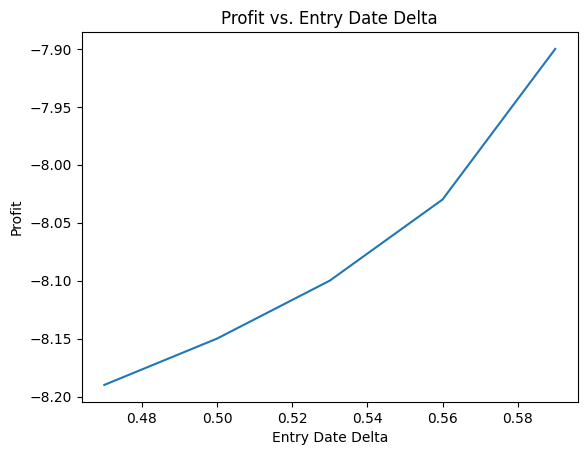

2023-12-29T10:00:00.000000000 - 2024-01-04T10:00:00.000000000 Exp 2024-01-05T00:00:00.000000000
476.765 - 468.84 = -7.925000000000011


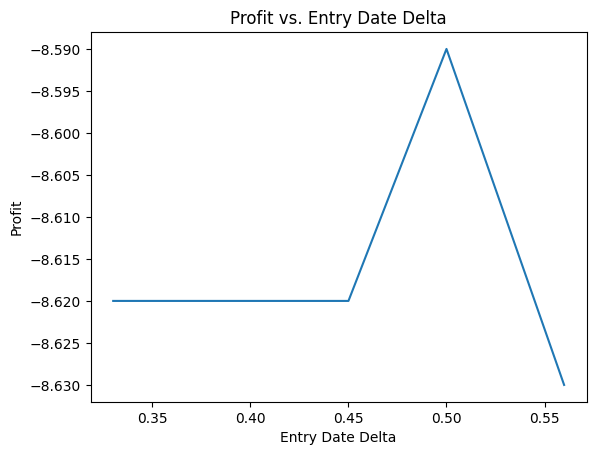

2023-12-29T10:00:00.000000000 - 2024-01-04T10:00:00.000000000 Exp 2024-01-12T00:00:00.000000000
476.765 - 468.84 = -7.925000000000011


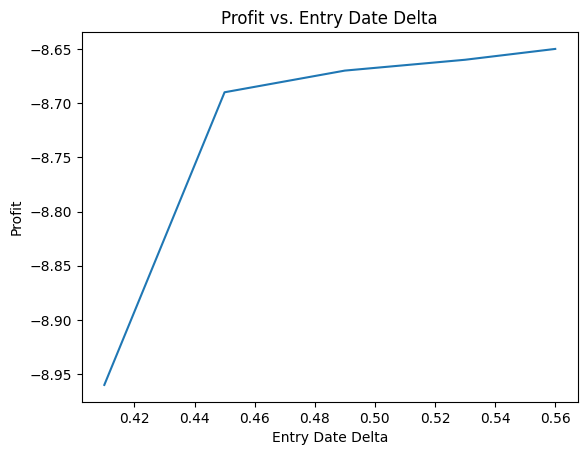

2023-12-29T10:00:00.000000000 - 2024-01-04T10:00:00.000000000 Exp 2024-01-19T00:00:00.000000000
476.765 - 468.84 = -7.925000000000011


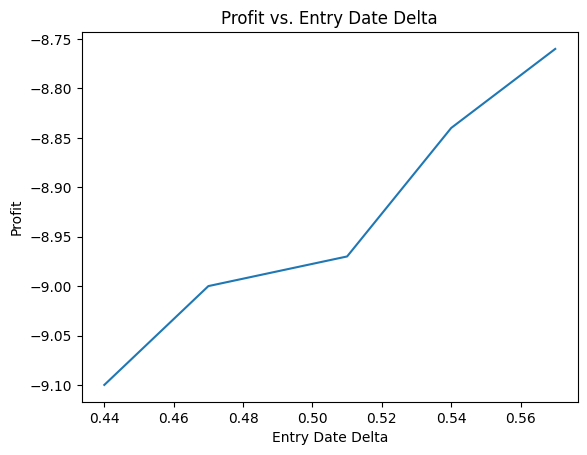

2024-01-01T10:00:00.000000000 - 2024-01-08T10:00:00.000000000 Exp 2024-01-12T00:00:00.000000000
475.31 - 469.755 = -5.555000000000007


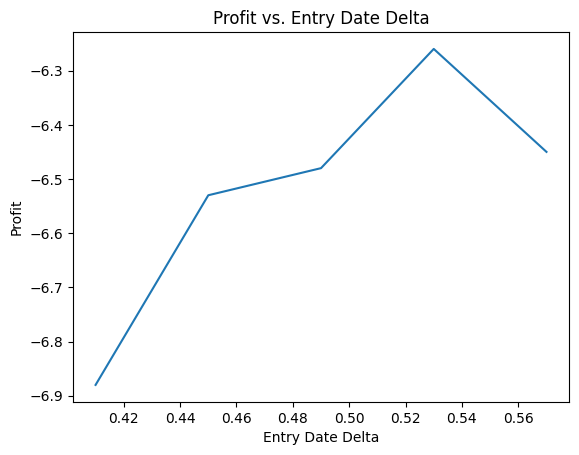

2024-01-01T10:00:00.000000000 - 2024-01-08T10:00:00.000000000 Exp 2024-01-19T00:00:00.000000000
475.31 - 469.755 = -5.555000000000007


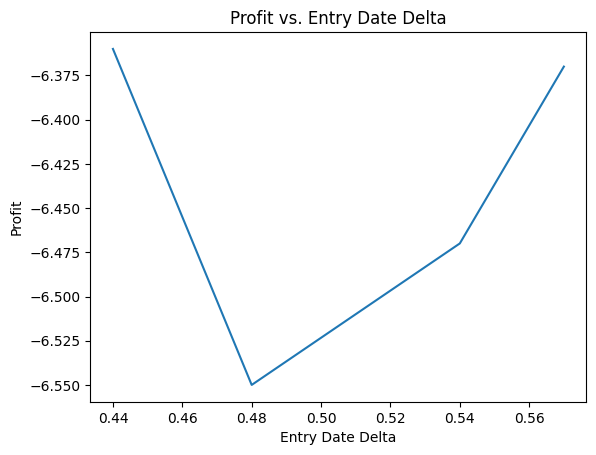

2024-01-01T10:00:00.000000000 - 2024-01-08T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
475.31 - 469.755 = -5.555000000000007


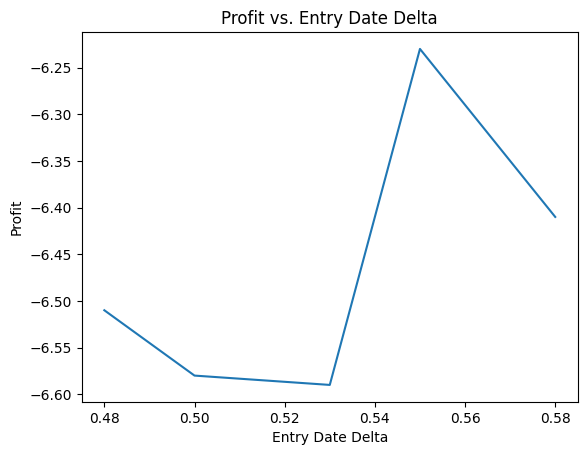

2024-01-02T10:00:00.000000000 - 2024-01-08T10:00:00.000000000 Exp 2024-01-12T00:00:00.000000000
472.16 - 469.755 = -2.4050000000000296


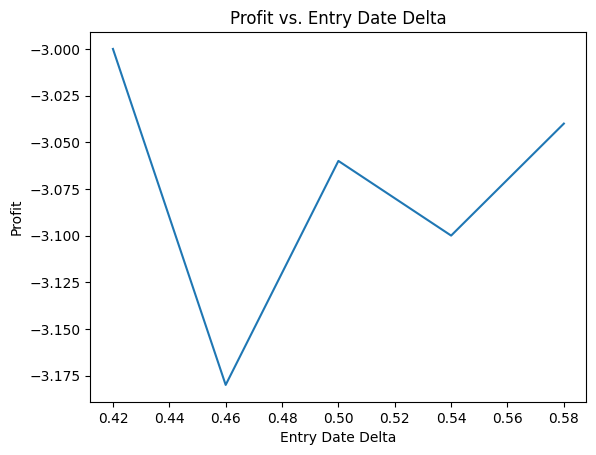

2024-01-02T10:00:00.000000000 - 2024-01-08T10:00:00.000000000 Exp 2024-01-19T00:00:00.000000000
472.16 - 469.755 = -2.4050000000000296


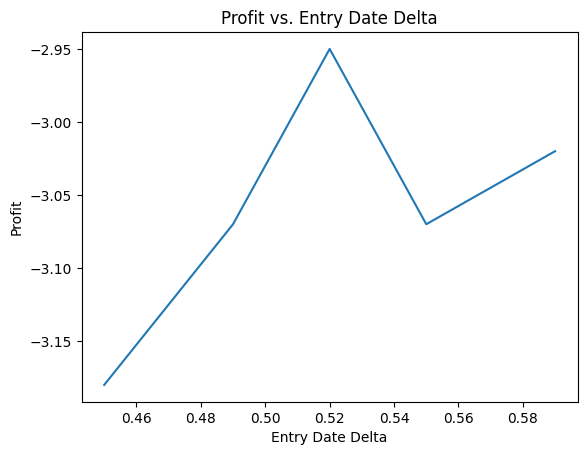

2024-01-02T10:00:00.000000000 - 2024-01-08T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
472.16 - 469.755 = -2.4050000000000296


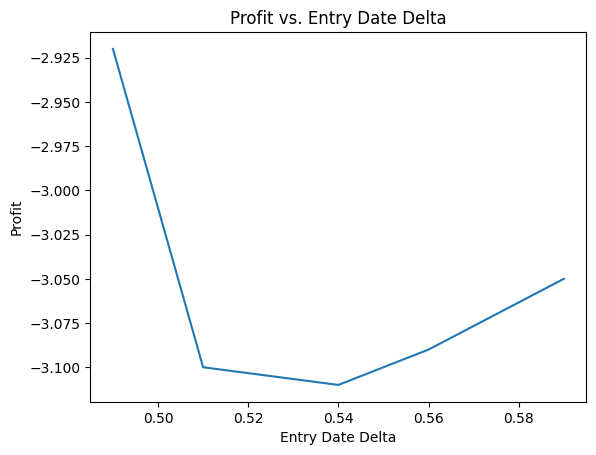

2024-01-03T10:00:00.000000000 - 2024-01-09T10:00:00.000000000 Exp 2024-01-12T00:00:00.000000000
469.83 - 472.165 = 2.3350000000000364


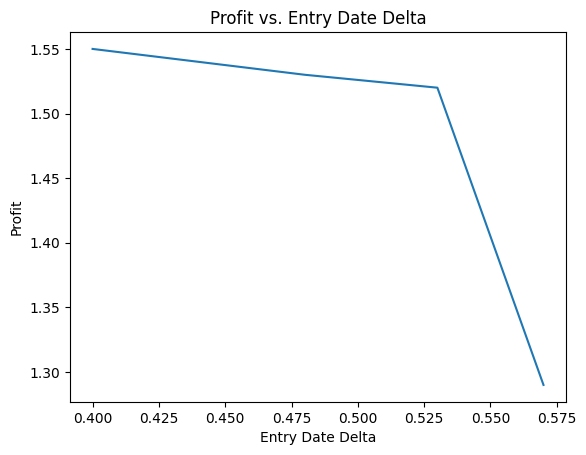

2024-01-03T10:00:00.000000000 - 2024-01-09T10:00:00.000000000 Exp 2024-01-19T00:00:00.000000000
469.83 - 472.165 = 2.3350000000000364


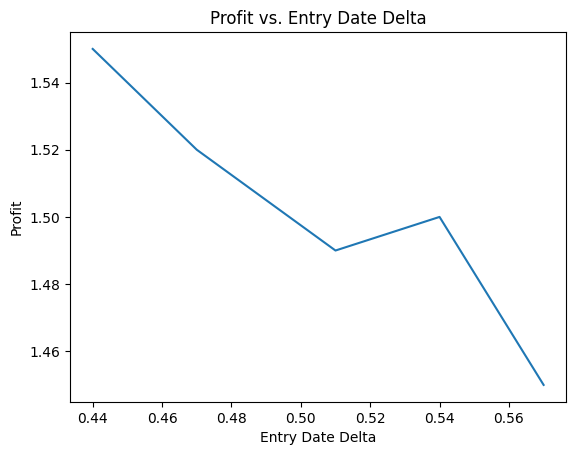

2024-01-03T10:00:00.000000000 - 2024-01-09T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
469.83 - 472.165 = 2.3350000000000364


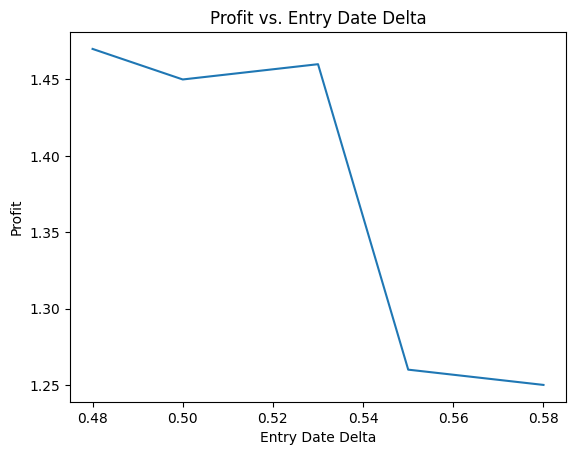

2024-01-04T10:00:00.000000000 - 2024-01-10T10:00:00.000000000 Exp 2024-01-12T00:00:00.000000000
468.84 - 474.7 = 5.860000000000014


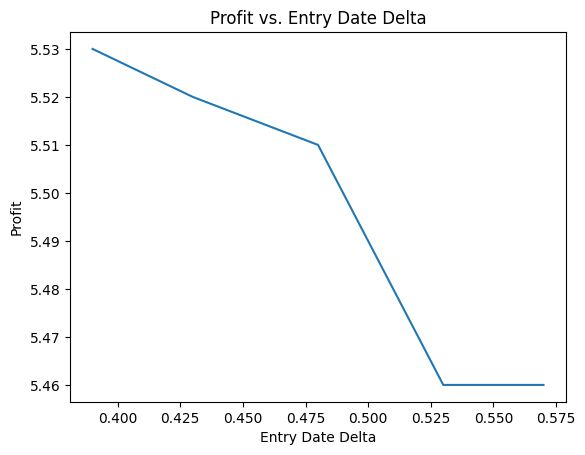

2024-01-04T10:00:00.000000000 - 2024-01-10T10:00:00.000000000 Exp 2024-01-19T00:00:00.000000000
468.84 - 474.7 = 5.860000000000014


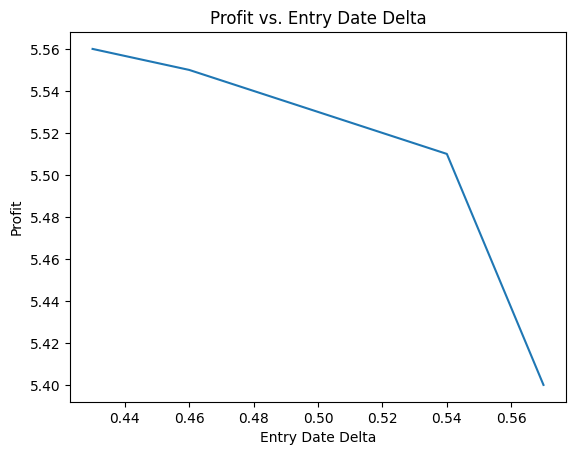

2024-01-04T10:00:00.000000000 - 2024-01-10T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
468.84 - 474.7 = 5.860000000000014


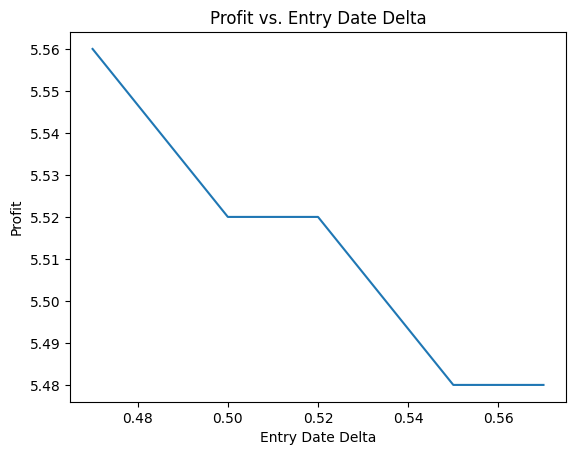

2024-01-05T10:00:00.000000000 - 2024-01-11T10:00:00.000000000 Exp 2024-01-12T00:00:00.000000000
468.5211 - 476.33 = 7.808899999999994


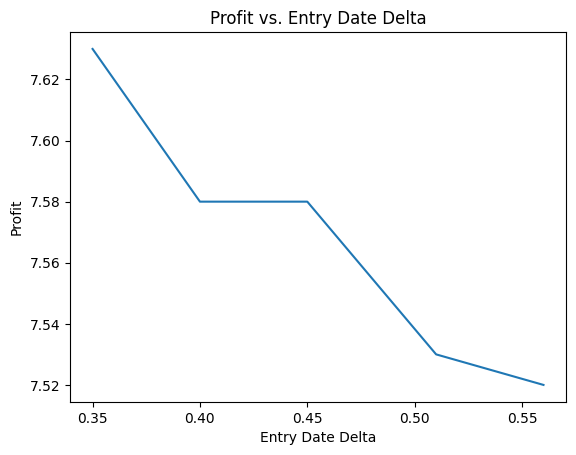

2024-01-05T10:00:00.000000000 - 2024-01-11T10:00:00.000000000 Exp 2024-01-19T00:00:00.000000000
468.5211 - 476.33 = 7.808899999999994


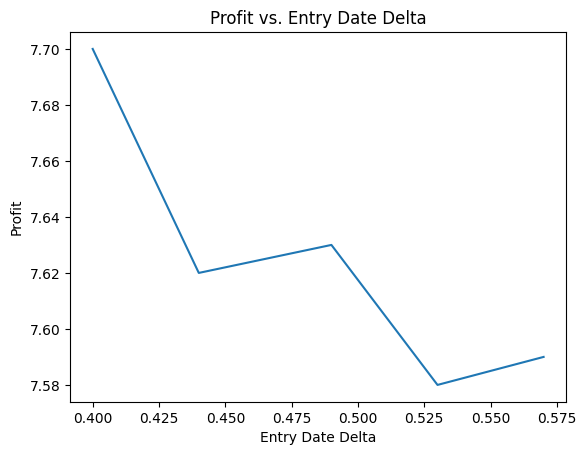

2024-01-05T10:00:00.000000000 - 2024-01-11T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
468.5211 - 476.33 = 7.808899999999994


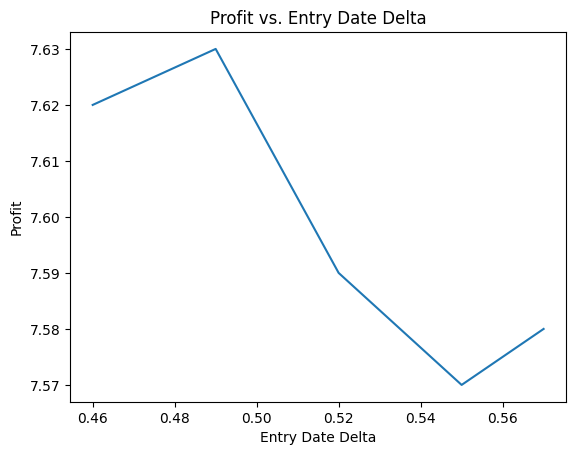

2024-01-08T10:00:00.000000000 - 2024-01-12T10:00:00.000000000 Exp 2024-01-19T00:00:00.000000000
469.755 - 477.17 = 7.4150000000000205


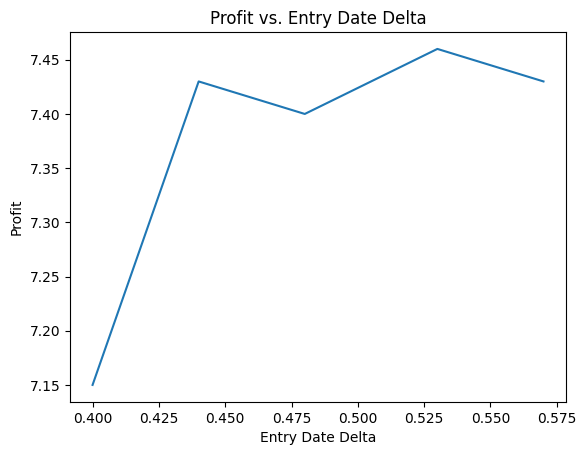

2024-01-08T10:00:00.000000000 - 2024-01-12T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
469.755 - 477.17 = 7.4150000000000205


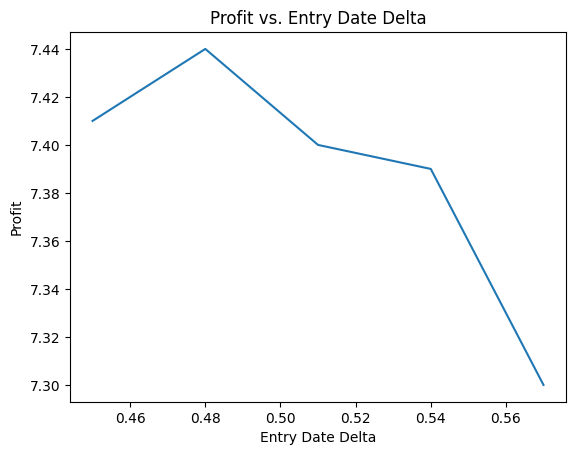

2024-01-08T10:00:00.000000000 - 2024-01-12T10:00:00.000000000 Exp 2024-02-16T00:00:00.000000000
469.755 - 477.17 = 7.4150000000000205


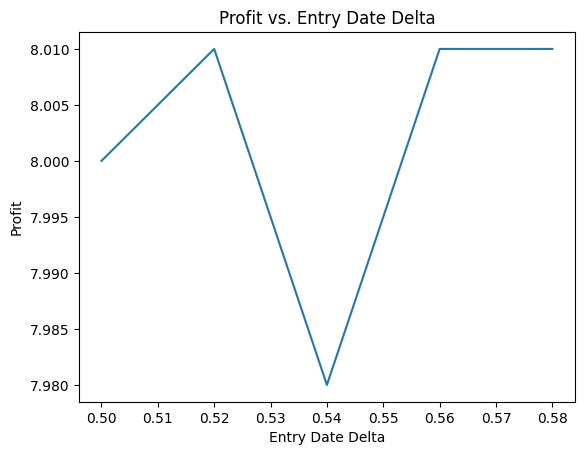

2024-01-09T10:00:00.000000000 - 2024-01-16T10:00:00.000000000 Exp 2024-01-19T00:00:00.000000000
472.165 - 474.5001 = 2.3350999999999544


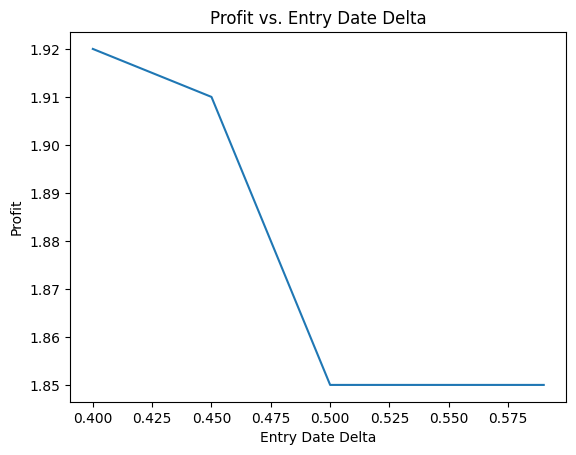

2024-01-09T10:00:00.000000000 - 2024-01-16T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
472.165 - 474.5001 = 2.3350999999999544


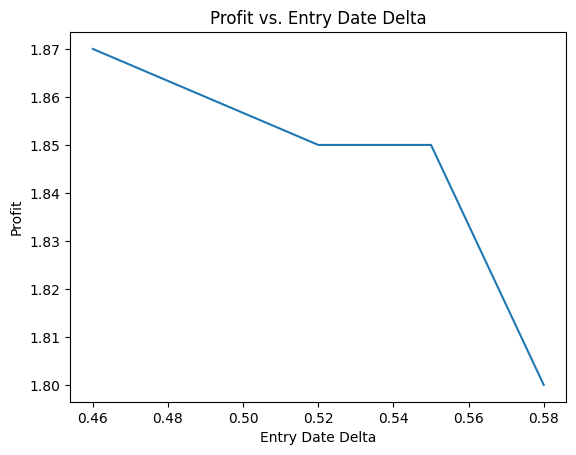

2024-01-09T10:00:00.000000000 - 2024-01-16T10:00:00.000000000 Exp 2024-02-16T00:00:00.000000000
472.165 - 474.5001 = 2.3350999999999544


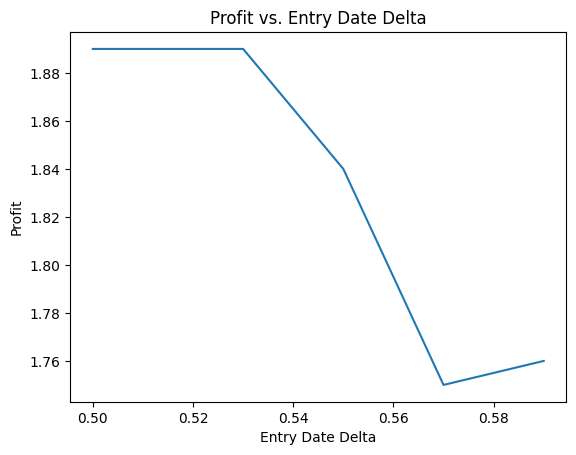

2024-01-10T10:00:00.000000000 - 2024-01-16T10:00:00.000000000 Exp 2024-01-19T00:00:00.000000000
474.7 - 474.5001 = -0.19990000000001373


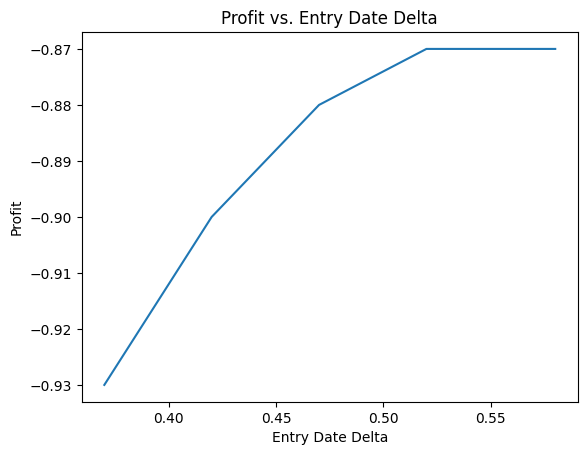

2024-01-10T10:00:00.000000000 - 2024-01-16T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
474.7 - 474.5001 = -0.19990000000001373


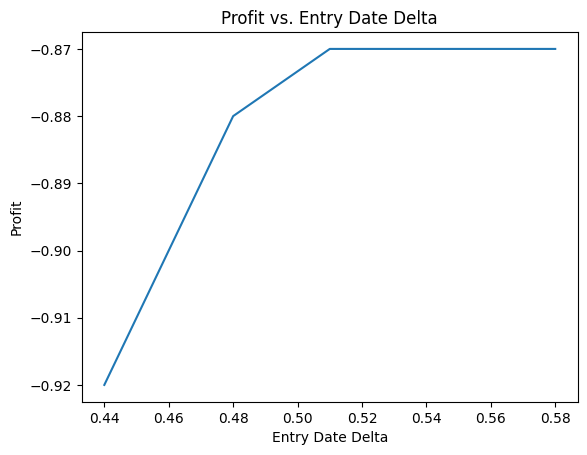

2024-01-10T10:00:00.000000000 - 2024-01-16T10:00:00.000000000 Exp 2024-02-16T00:00:00.000000000
474.7 - 474.5001 = -0.19990000000001373


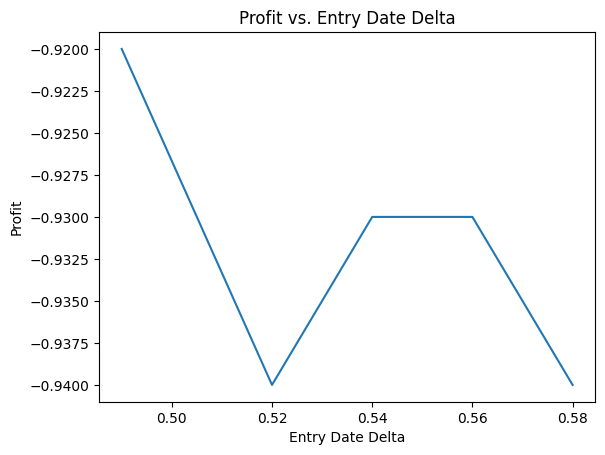

2024-01-11T10:00:00.000000000 - 2024-01-17T10:00:00.000000000 Exp 2024-01-19T00:00:00.000000000
476.33 - 471.325 = -5.0049999999999955


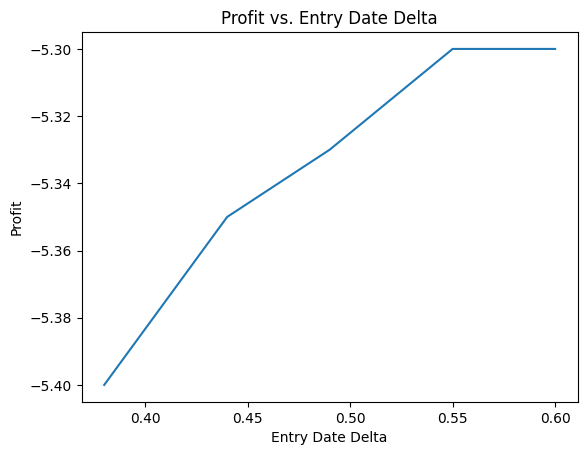

2024-01-11T10:00:00.000000000 - 2024-01-17T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
476.33 - 471.325 = -5.0049999999999955


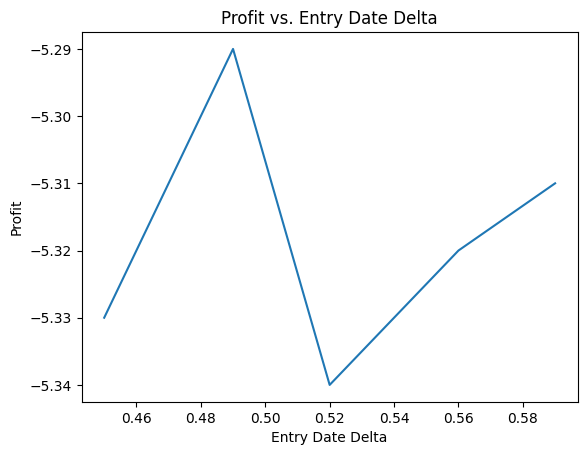

2024-01-11T10:00:00.000000000 - 2024-01-17T10:00:00.000000000 Exp 2024-02-16T00:00:00.000000000
476.33 - 471.325 = -5.0049999999999955


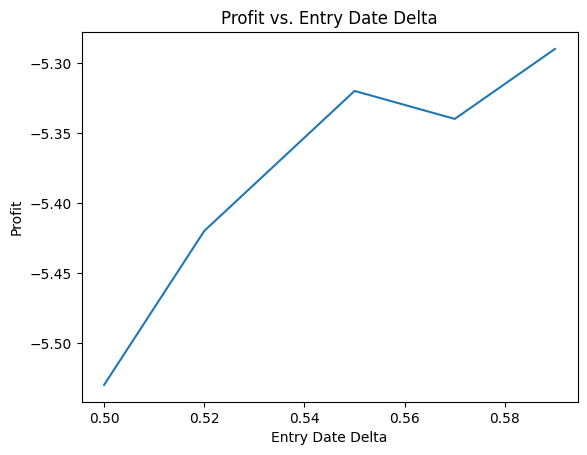

2024-01-12T10:00:00.000000000 - 2024-01-18T10:00:00.000000000 Exp 2024-01-19T00:00:00.000000000
477.17 - 473.9 = -3.2700000000000387


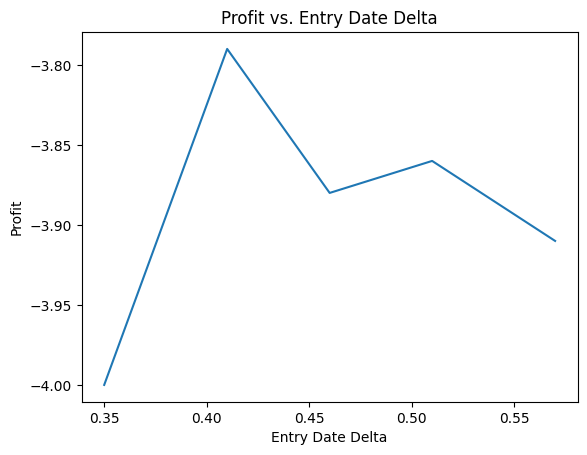

2024-01-12T10:00:00.000000000 - 2024-01-18T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
477.17 - 473.9 = -3.2700000000000387


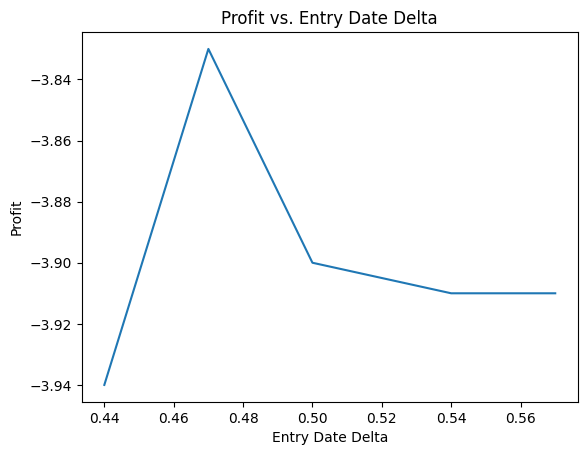

2024-01-12T10:00:00.000000000 - 2024-01-18T10:00:00.000000000 Exp 2024-02-16T00:00:00.000000000
477.17 - 473.9 = -3.2700000000000387


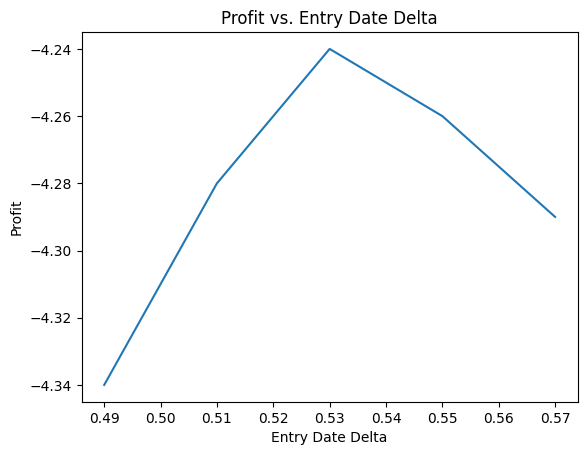

2024-01-16T10:00:00.000000000 - 2024-01-22T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
474.5001 - 485.06 = 10.559900000000027


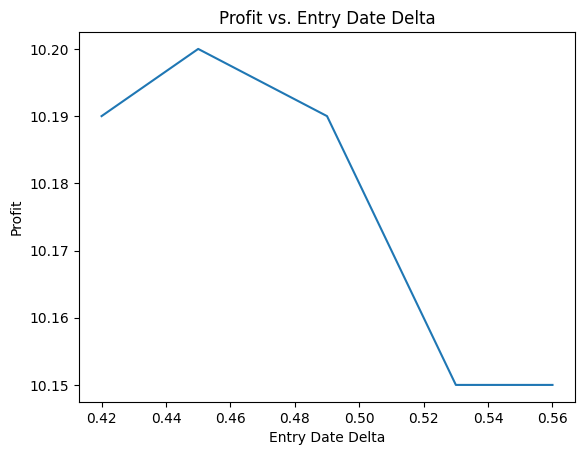

2024-01-16T10:00:00.000000000 - 2024-01-22T10:00:00.000000000 Exp 2024-02-16T00:00:00.000000000
474.5001 - 485.06 = 10.559900000000027


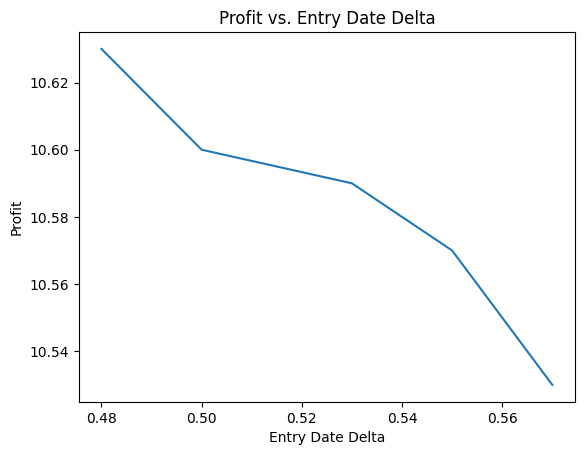

2024-01-16T10:00:00.000000000 - 2024-01-22T10:00:00.000000000 Exp 2024-02-29T00:00:00.000000000
474.5001 - 485.06 = 10.559900000000027


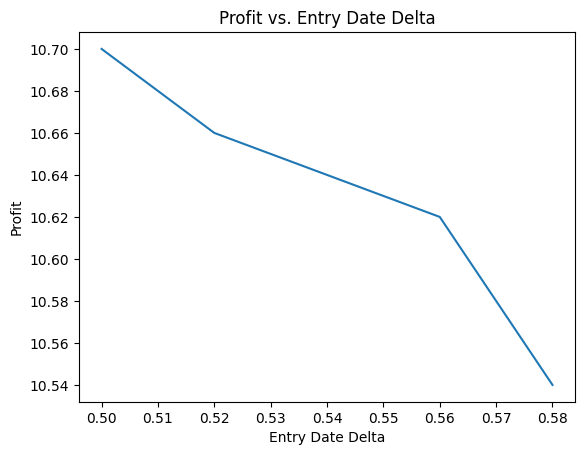

2024-01-17T10:00:00.000000000 - 2024-01-23T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
471.325 - 483.98 = 12.65500000000003


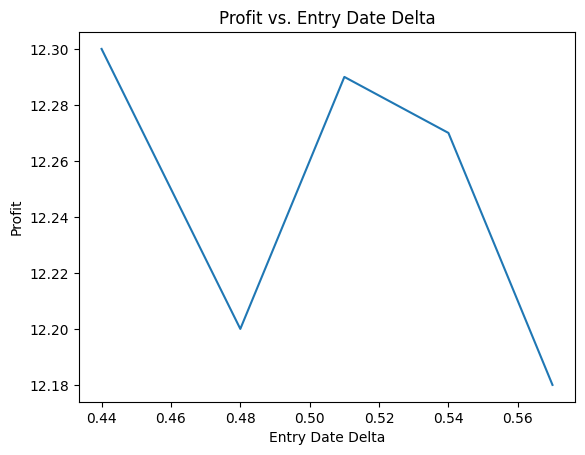

2024-01-17T10:00:00.000000000 - 2024-01-23T10:00:00.000000000 Exp 2024-02-16T00:00:00.000000000
471.325 - 483.98 = 12.65500000000003


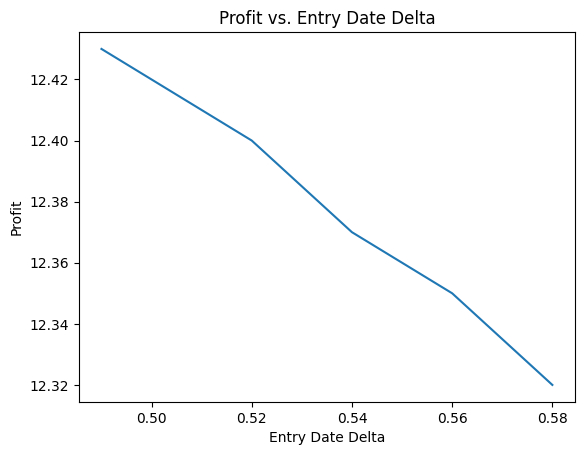

2024-01-17T10:00:00.000000000 - 2024-01-23T10:00:00.000000000 Exp 2024-02-29T00:00:00.000000000
471.325 - 483.98 = 12.65500000000003


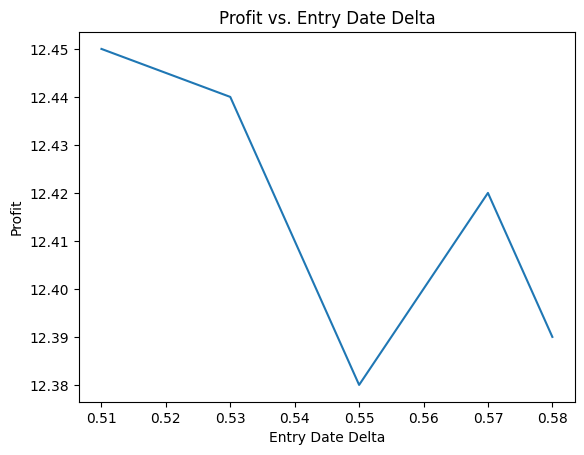

2024-01-18T10:00:00.000000000 - 2024-01-24T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
473.9 - 487.1 = 13.200000000000045


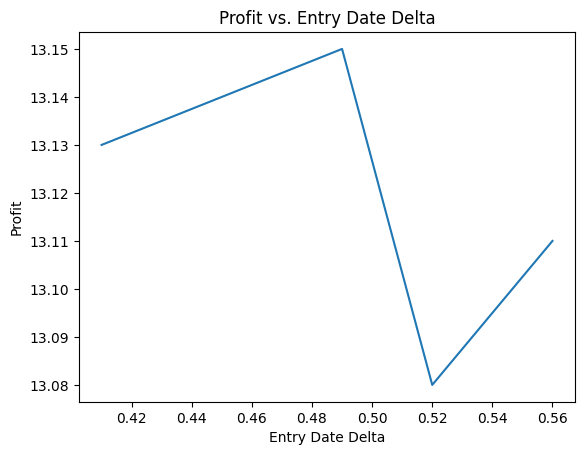

2024-01-18T10:00:00.000000000 - 2024-01-24T10:00:00.000000000 Exp 2024-02-16T00:00:00.000000000
473.9 - 487.1 = 13.200000000000045


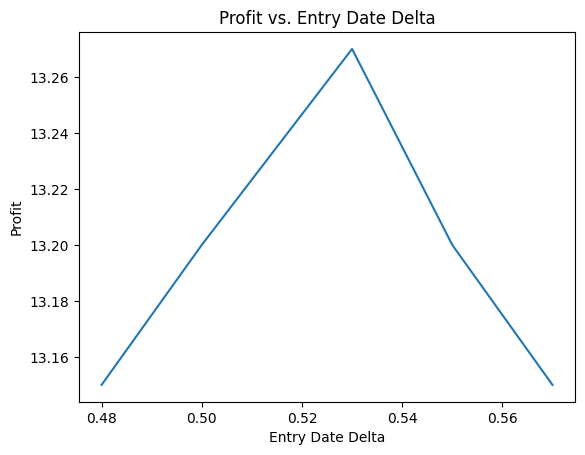

2024-01-18T10:00:00.000000000 - 2024-01-24T10:00:00.000000000 Exp 2024-02-29T00:00:00.000000000
473.9 - 487.1 = 13.200000000000045


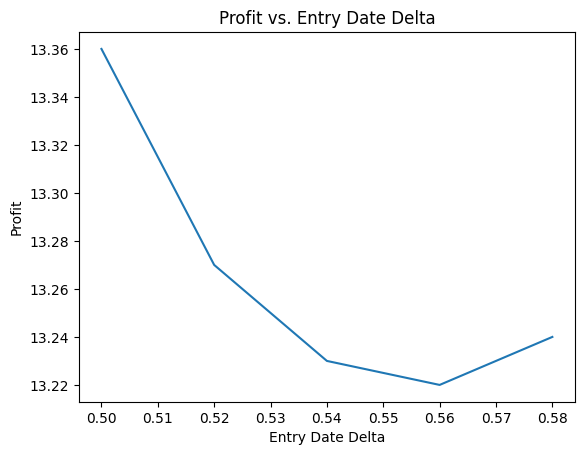

2024-01-19T10:00:00.000000000 - 2024-01-25T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
478.16 - 487.33 = 9.169999999999959


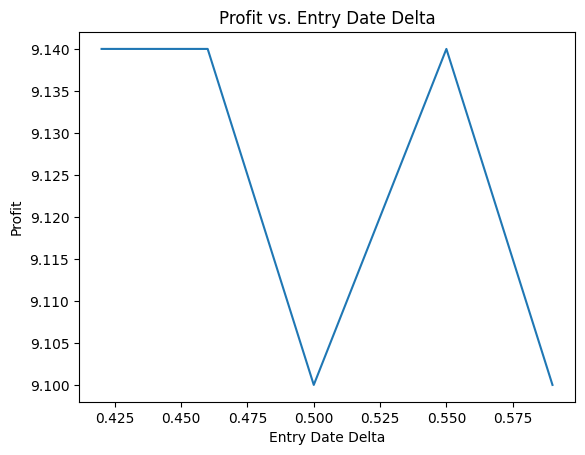

2024-01-19T10:00:00.000000000 - 2024-01-25T10:00:00.000000000 Exp 2024-02-16T00:00:00.000000000
478.16 - 487.33 = 9.169999999999959


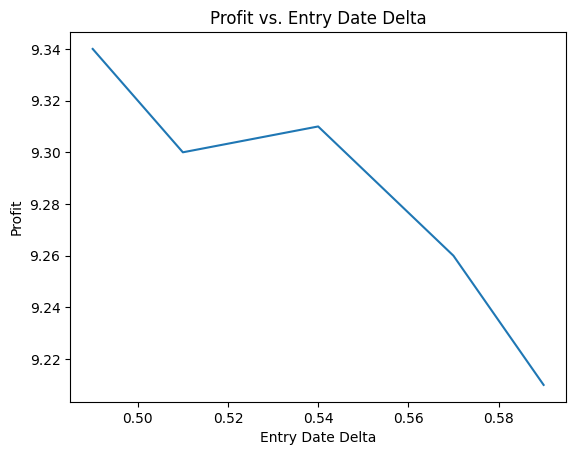

2024-01-19T10:00:00.000000000 - 2024-01-25T10:00:00.000000000 Exp 2024-02-29T00:00:00.000000000
478.16 - 487.33 = 9.169999999999959


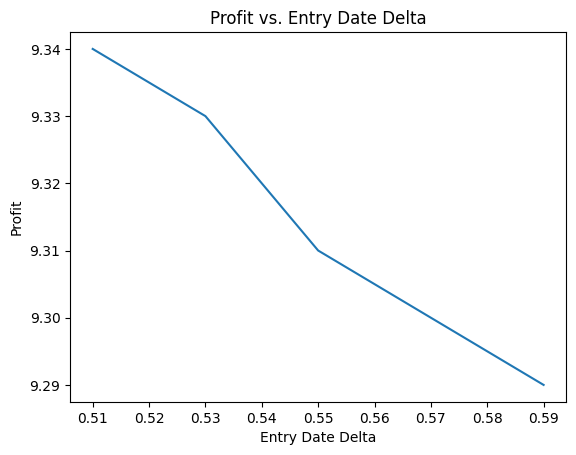

2024-01-22T10:00:00.000000000 - 2024-01-29T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
485.06 - 488.02 = 2.9599999999999795


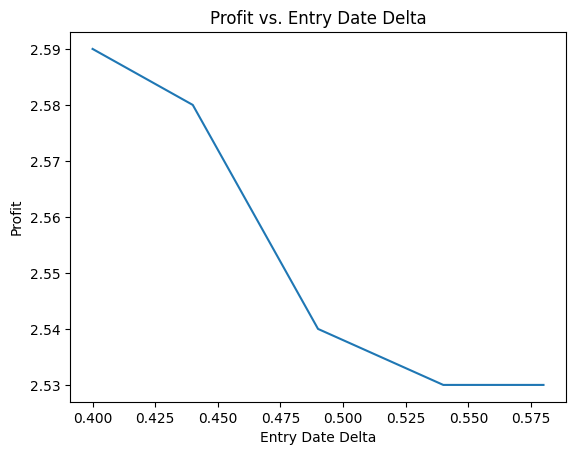

2024-01-22T10:00:00.000000000 - 2024-01-29T10:00:00.000000000 Exp 2024-02-16T00:00:00.000000000
485.06 - 488.02 = 2.9599999999999795


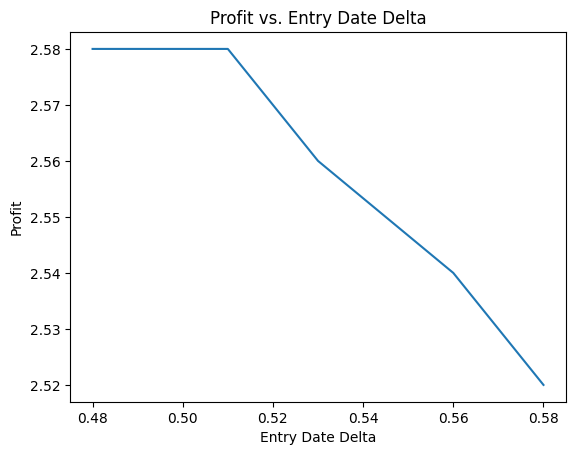

2024-01-22T10:00:00.000000000 - 2024-01-29T10:00:00.000000000 Exp 2024-02-29T00:00:00.000000000
485.06 - 488.02 = 2.9599999999999795


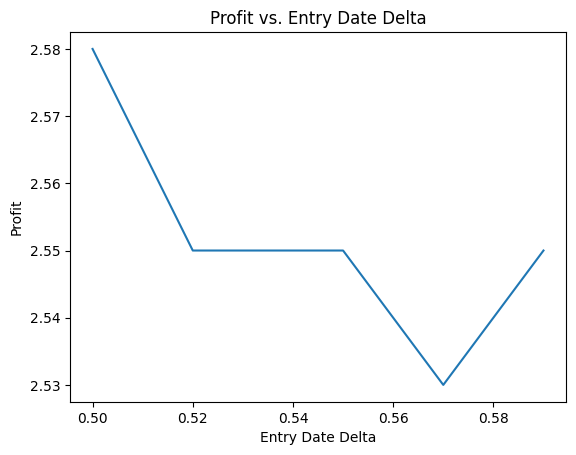

2024-01-23T10:00:00.000000000 - 2024-01-29T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
483.98 - 488.02 = 4.039999999999964


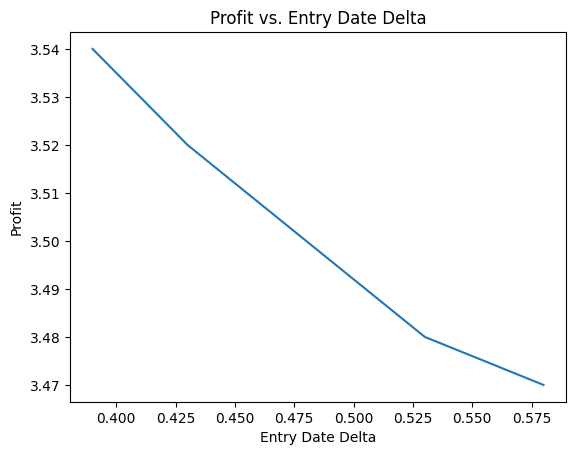

2024-01-23T10:00:00.000000000 - 2024-01-29T10:00:00.000000000 Exp 2024-02-16T00:00:00.000000000
483.98 - 488.02 = 4.039999999999964


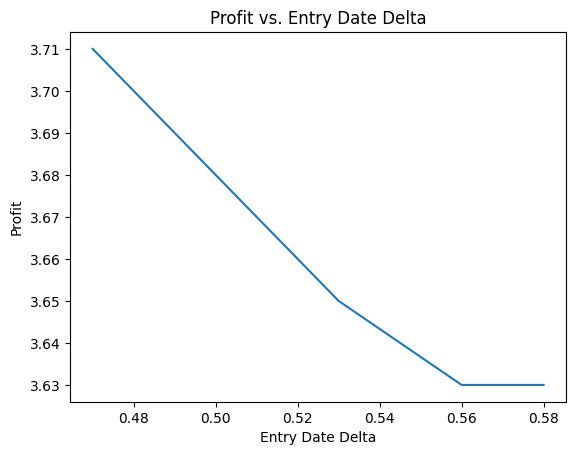

2024-01-23T10:00:00.000000000 - 2024-01-29T10:00:00.000000000 Exp 2024-02-29T00:00:00.000000000
483.98 - 488.02 = 4.039999999999964


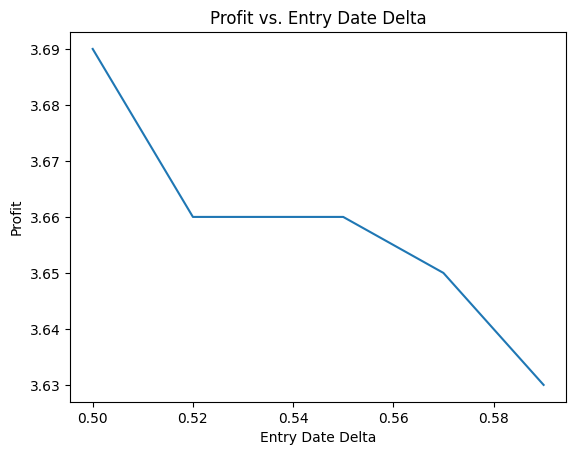

2024-01-24T10:00:00.000000000 - 2024-01-30T10:00:00.000000000 Exp 2024-01-31T00:00:00.000000000
487.1 - 491.28 = 4.17999999999995


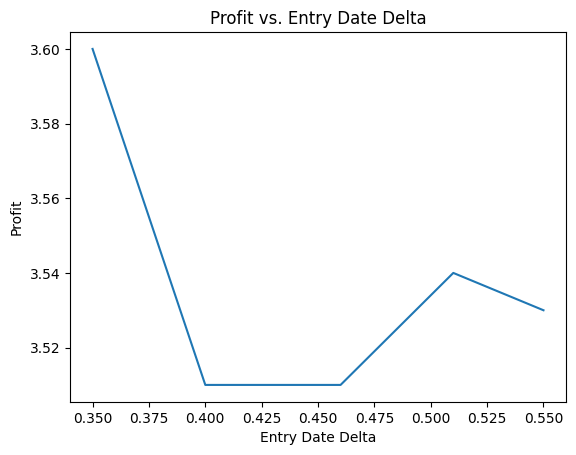

2024-01-24T10:00:00.000000000 - 2024-01-30T10:00:00.000000000 Exp 2024-02-16T00:00:00.000000000
487.1 - 491.28 = 4.17999999999995


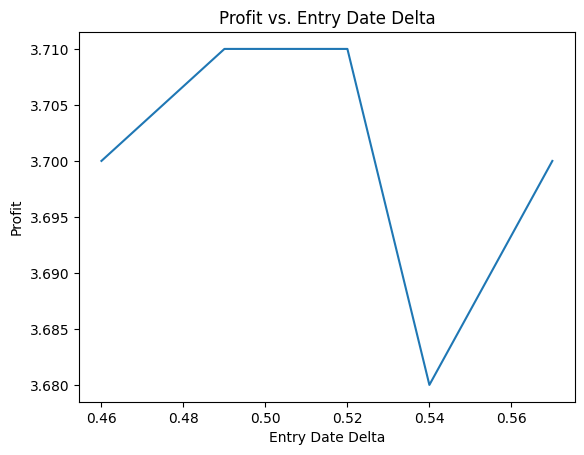

2024-01-24T10:00:00.000000000 - 2024-01-30T10:00:00.000000000 Exp 2024-02-29T00:00:00.000000000
487.1 - 491.28 = 4.17999999999995


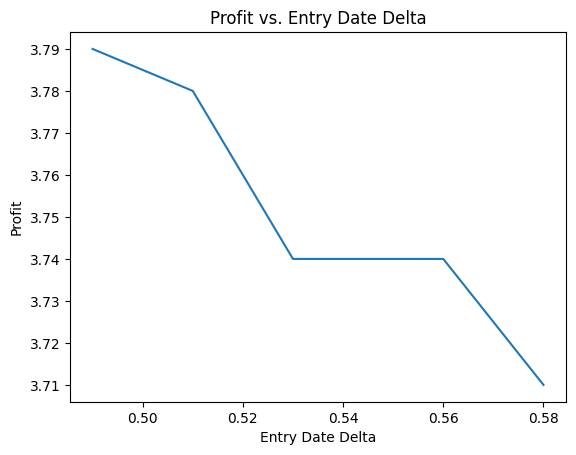

2024-01-25T10:00:00.000000000 - 2024-01-31T10:00:00.000000000 Exp 2024-02-16T00:00:00.000000000
487.33 - 487.7602 = 0.43020000000001346


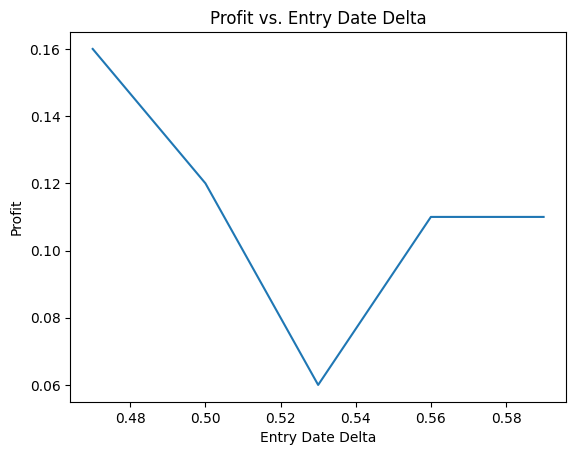

2024-01-25T10:00:00.000000000 - 2024-01-31T10:00:00.000000000 Exp 2024-02-29T00:00:00.000000000
487.33 - 487.7602 = 0.43020000000001346


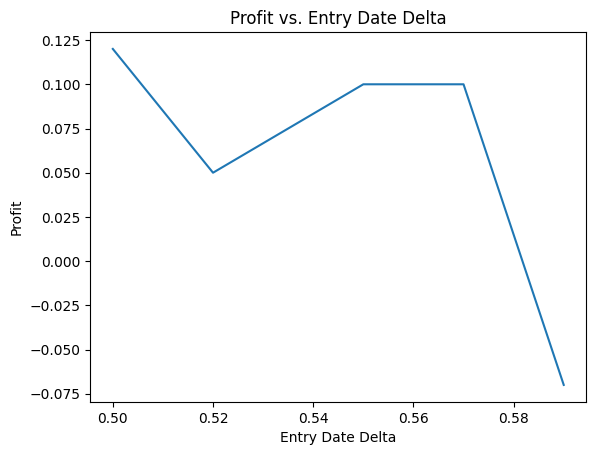

2024-01-25T10:00:00.000000000 - 2024-01-31T10:00:00.000000000 Exp 2024-03-15T00:00:00.000000000
487.33 - 487.7602 = 0.43020000000001346


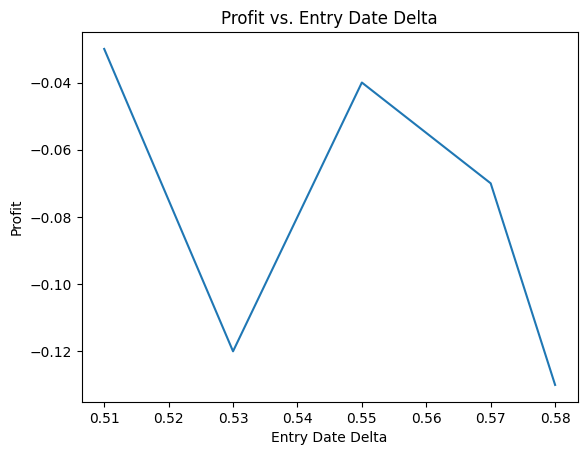

2024-01-26T10:00:00.000000000 - 2024-01-31T10:00:00.000000000 Exp 2024-02-16T00:00:00.000000000
487.65 - 487.7602 = 0.11020000000002028


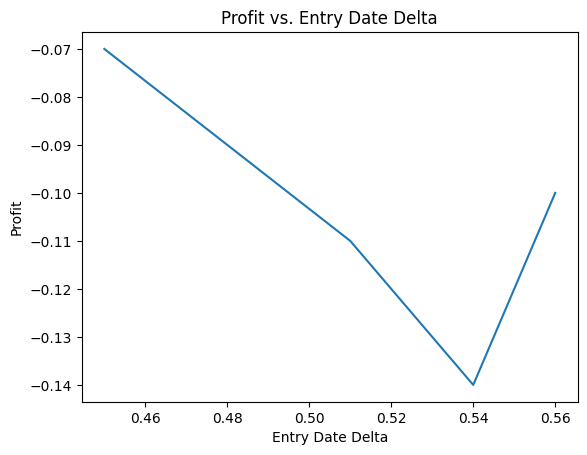

2024-01-26T10:00:00.000000000 - 2024-01-31T10:00:00.000000000 Exp 2024-02-29T00:00:00.000000000
487.65 - 487.7602 = 0.11020000000002028


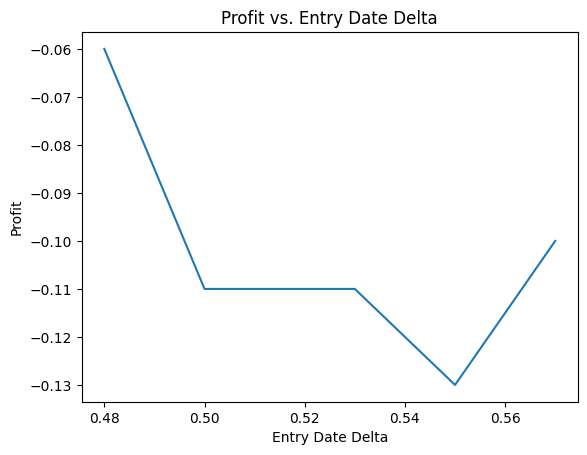

2024-01-26T10:00:00.000000000 - 2024-01-31T10:00:00.000000000 Exp 2024-03-15T00:00:00.000000000
487.65 - 487.7602 = 0.11020000000002028


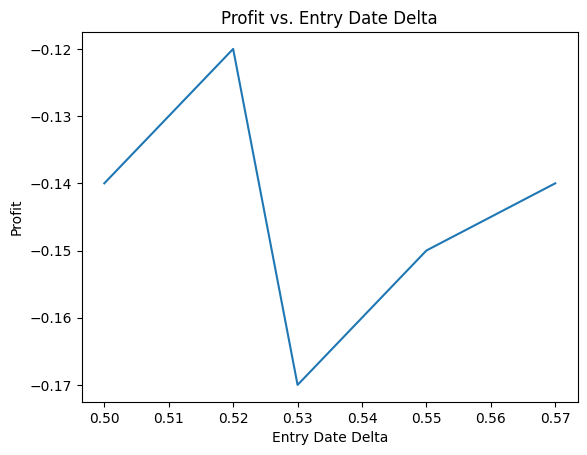

2024-01-29T10:00:00.000000000 - 2024-01-31T10:00:00.000000000 Exp 2024-02-16T00:00:00.000000000
488.02 - 487.7602 = -0.25979999999998427


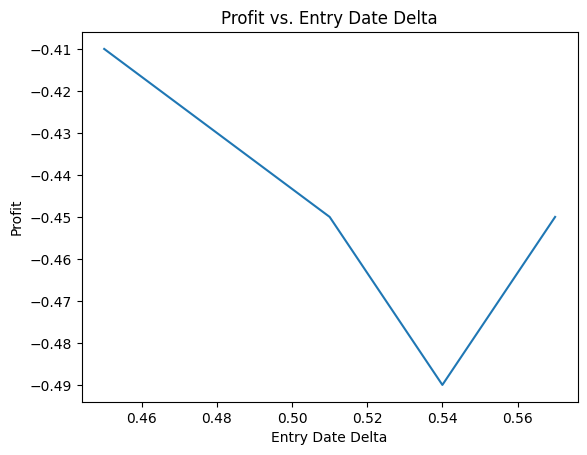

2024-01-29T10:00:00.000000000 - 2024-01-31T10:00:00.000000000 Exp 2024-02-29T00:00:00.000000000
488.02 - 487.7602 = -0.25979999999998427


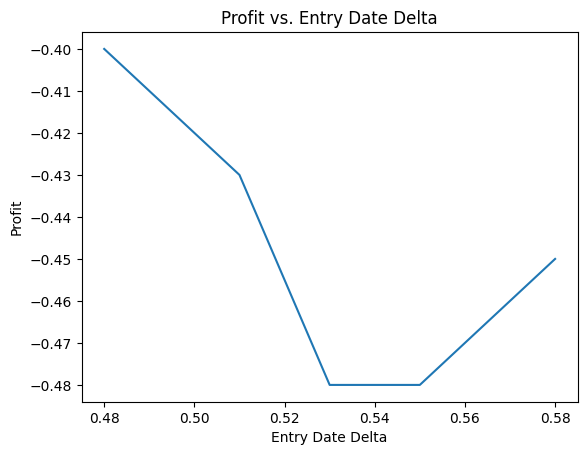

2024-01-29T10:00:00.000000000 - 2024-01-31T10:00:00.000000000 Exp 2024-03-15T00:00:00.000000000
488.02 - 487.7602 = -0.25979999999998427


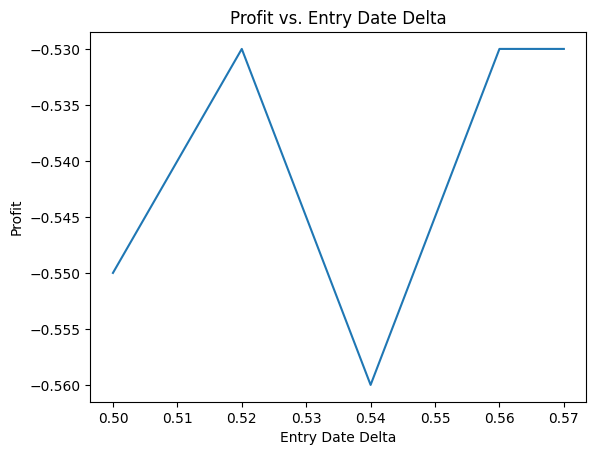

2024-01-30T10:00:00.000000000 - 2024-01-31T10:00:00.000000000 Exp 2024-02-16T00:00:00.000000000
491.28 - 487.7602 = -3.519799999999975


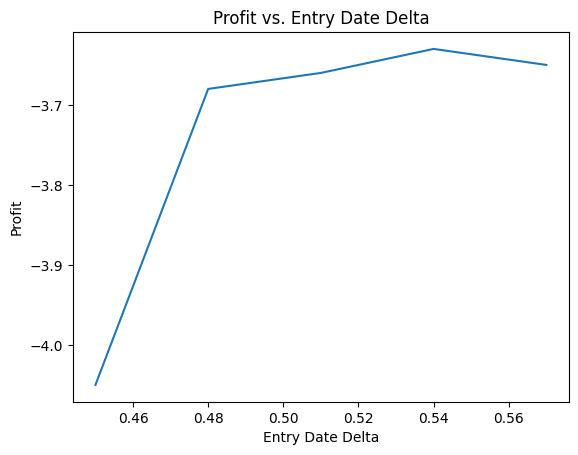

2024-01-30T10:00:00.000000000 - 2024-01-31T10:00:00.000000000 Exp 2024-02-29T00:00:00.000000000
491.28 - 487.7602 = -3.519799999999975


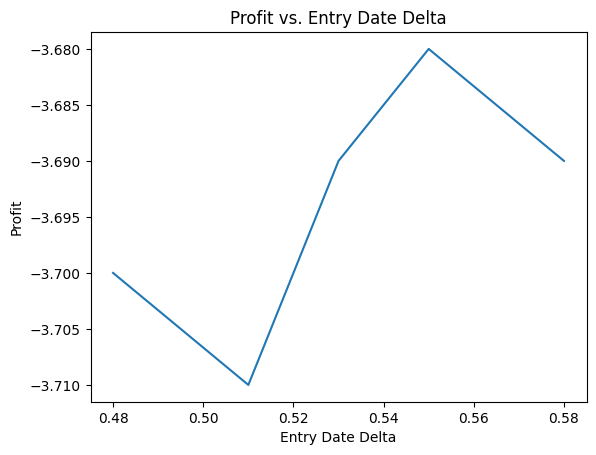

2024-01-30T10:00:00.000000000 - 2024-01-31T10:00:00.000000000 Exp 2024-03-15T00:00:00.000000000
491.28 - 487.7602 = -3.519799999999975


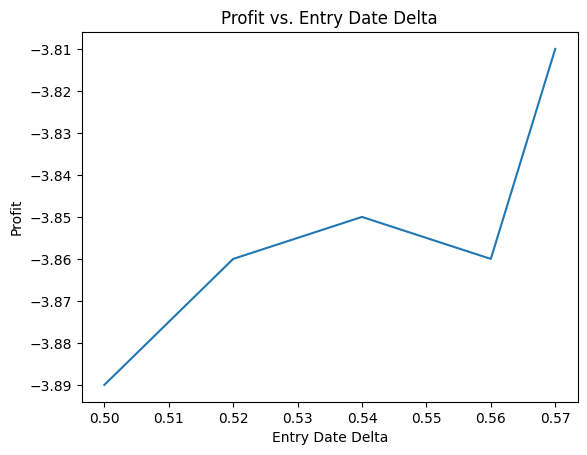

In [ ]:
for date in unique_Timestamps:
  date_count = 0
  for exp in unique_Exps:
      days_to_add = 7
      closest_timestamp = Closest_Exp(date, unique_Timestamps, days_to_add-1)
      closest_exp_date = Closest_Exp(closest_timestamp, unique_Exps, days_to_add)
      Strategy_Entry_Date = date
      Exp_Date = exp
      Strategy_Exit_Date = closest_timestamp


      if (Strategy_Entry_Date < Strategy_Exit_Date) & (Exp_Date > Strategy_Exit_Date) & (date_count < 3):
        spy_price_on_entry, spy_price_on_exit, spy_profit, results_df = analyze_synthetic_long(Strategy_Entry_Date, Strategy_Exit_Date, Exp_Date)

        print (f'{Strategy_Entry_Date} - {Strategy_Exit_Date} Exp {Exp_Date}')
        print (f'{spy_price_on_entry} - {spy_price_on_exit} = {spy_profit}')
        # display(results_df)
        plot_Profit_vs_Delta(results_df)
        date_count += 1


In [ ]:
df_results = pd.DataFrame()
df_best_results = pd.DataFrame()
# Apply the filter
for date in unique_Timestamps:
  for exp in unique_Exps:
      days_to_add = 7
      closest_timestamp = Closest_Exp(date, unique_Timestamps, days_to_add)
      closest_exp_date = Closest_Exp(closest_timestamp, unique_Exps, days_to_add)
      Strategy_Entry_Date = date
      # Strategy_Entry_Date = '2022-09-22T15:00:00.000000000'
      Exp_Date = exp
      # Exp_Date = '2022-12-16T00:00:00.000000000'
      Strategy_Exit_Date = closest_timestamp
      # Strategy_Exit_Date = '2022-12-15T15:00:00.000000000'

      if (Strategy_Entry_Date < Strategy_Exit_Date) & (Exp_Date > Strategy_Entry_Date) & (Exp_Date > Strategy_Exit_Date):
        df_filtered = df[(df['Exp'] == Exp_Date)].copy()

        # Sort the filtered DataFrame by 'Timestamp' within each group defined by 'Exp' and 'Strike'
        df_filtered_sorted = df_filtered.sort_values(by='Timestamp')

        # Group the sorted DataFrame
        df_grouped_filtered_sorted = df_filtered_sorted.groupby(['Exp', 'Strike'])

        # Filter the DataFrame to find the row corresponding to the Strategy Exit Date for each group
        exit_rows = df_filtered_sorted[df_filtered_sorted['Timestamp'] == Strategy_Exit_Date]

        # Map the 'Synthetic Long_Exit' and 'Underlying Price' from the exit rows back to the grouped DataFrame
        exit_rows = df_filtered_sorted[df_filtered_sorted['Timestamp'] == Strategy_Exit_Date]
        df_filtered_sorted['Synthetic Long_End'] = df_grouped_filtered_sorted['Strike'].transform(
            lambda x: exit_rows.loc[exit_rows['Strike'] == x.iloc[0], 'Synthetic Long_Exit'].iloc[0]
            if not exit_rows.loc[exit_rows['Strike'] == x.iloc[0]].empty else np.nan)
        df_filtered_sorted['Underlying Price_End'] = df_grouped_filtered_sorted['Strike'].transform(
            lambda x: exit_rows.loc[exit_rows['Strike'] == x.iloc[0], 'Underlying Price'].iloc[0]
            if not exit_rows.loc[exit_rows['Strike'] == x.iloc[0]].empty else np.nan)

        # Calculate 'Profit/Loss' for each row
        df_filtered_sorted['Profit/Loss'] = df_filtered_sorted['Synthetic Long'] + df_filtered_sorted['Synthetic Long_End']

        # Calculate 'Underlying Change' for each row
        df_filtered_sorted['Underlying Change'] = df_filtered_sorted['Underlying Price_End'] - df_filtered_sorted['Underlying Price']

        # Calculate 'Percent Max' for each row
        df_filtered_sorted['Percent Max'] = df_filtered_sorted['Profit/Loss'] / df_filtered_sorted['Underlying Change']

        # Calculate the difference in days and store it as 'DTE'
        df_filtered_sorted['DTE'] = (df_filtered_sorted['Exp'] - df_filtered_sorted['Timestamp']).dt.days

        cols_to_show = ['Timestamp','Exit_Date','Exp','DTE','Strike','Call Delta','Put Delta','Percent Max','Underlying Price','Underlying Price_End','Underlying Change','Profit/Loss']

        if len(df_filtered_sorted) > 0:
          # display(df_filtered_sorted[cols_to_show].sort_values(by='Percent Max', ascending=False).head(2))
          df_to_add = df_filtered_sorted.copy()
          df_to_add['Exit_Date'] = Strategy_Exit_Date
          df_results = pd.concat([df_results, df_to_add], ignore_index=True)
          df_best_results = pd.concat([df_best_results, df_to_add.head(1)], ignore_index=True)


        else:
          print(f"Closest 1W Expiry Date to {date} is {closest_exp_date}")
          print(f"Strategy_Entry_Date: {Strategy_Entry_Date}")
          print(f"Strategy_Exit_Date: {Strategy_Exit_Date} ")
          print(f"Exp_Date: {Exp_Date}")
          print(f"Price Entry {df_filtered[df_filtered['Timestamp'] == Strategy_Entry_Date]['Underlying Price'].min()}")
          print(f"Price Exit {df_filtered[df_filtered['Timestamp'] == Strategy_Exit_Date]['Underlying Price'].min()}")


KeyboardInterrupt: 

In [ ]:
# display(df_results)
# Remove duplicate rows from the DataFrame
# df_unique_results = df_results.drop_duplicates(keep='first', inplace=False)
display(df_results[cols_to_show].sort_values(by='Percent Max', ascending=False))
# display(df_best_results[cols_to_show].sort_values(by='Percent Max', ascending=False))

In [ ]:
cols_to_show = ['Timestamp','Exit_Date','Exp','DTE','Strike','Call Delta','Put Delta','Percent Max','Underlying Price','Underlying Price_End','Underlying Change','Profit/Loss','Synthetic Long','Call ASK','Put BID','Put Open.Int', 'Call Open.Int']
display(df_results[cols_to_show].sort_values(by='Percent Max', ascending=False))

In [ ]:
#df_results.to_csv('results.csv',index=False)
df_best_results.to_csv('best results.csv',index=False)

In [ ]:
df_best_results

In [ ]:
df = df

# Define the parameters for analysis
entry_date = "2023-12-01 10:00:00"
exit_date = "2023-12-06 10:00:00"
strikes = list(range(456, 458))
expiration_date = "2023-12-07"

# Filter for SPY and specific strikes at the entry date
spy_row_identifier = df['Strike'].isna() | (df['Strike'] == '-')
spy_df = df[spy_row_identifier & (df['Timestamp'] == entry_date)]
strikes_df = df[df['Strike'].isin(strikes) & (df['Timestamp'] == entry_date) & (df['Exp'] == expiration_date)]

# Combine SPY and strike data
combined_df = pd.concat([spy_df, strikes_df])

# Select and calculate the necessary columns
combined_df['Entry Date Strategy Price'] = combined_df['Put BID'] - combined_df['Call ASK']


# Function to calculate the exit strategy price for a given strike
def calculate_exit_strategy_price(row, df):
    # Filter the DataFrame for the given strike and option expiration
    df_filtered = df[(df['Strike'] == row['Strike']) & (df['Exp'] == row['Exp']) & (df['Timestamp'] == exit_date)]
    if not df_filtered.empty:
        call_bid = df_filtered['Call BID'].iloc[0]
        put_ask = df_filtered['Put ASK'].iloc[0]
        return call_bid - put_ask
    return None

# Applying the function to calculate 'Exit Date Strategy Price' for each row in combined_df
combined_df['Exit Date Strategy Price'] = combined_df.apply(lambda row: calculate_exit_strategy_price(row, df_results), axis=1)


combined_df['Profit'] = combined_df['Entry Date Strategy Price'] + combined_df['Exit Date Strategy Price']
combined_df['Breakeven'] = combined_df['Strike'] - combined_df['Entry Date Strategy Price']

# Calculate SPY's price change
spy_entry_price = df.loc[df['Timestamp'] == entry_date, 'Underlying Price'].iloc[0]
spy_exit_price = df.loc[df['Timestamp'] == exit_date, 'Underlying Price'].iloc[0]
spy_price_change = spy_exit_price - spy_entry_price

# Calculate % SPY
combined_df['% SPY'] = (combined_df['Profit'] / spy_price_change) * 100

# Rearrange and select columns for final display
final_columns = [
    'Strike', 'Call ASK', 'Put BID', 'Call Delta', 'Put Delta',
    'Breakeven', 'Entry Date Strategy Price', 'Call BID', 'Put ASK', 'Exit Date Strategy Price', 'Profit', '% SPY'
]
combined_df = combined_df[final_columns]
combined_df.insert(0, "Entry Date", entry_date)
combined_df.insert(1, "Exit Date", exit_date)
combined_df.insert(2, "Option Expiration", expiration_date)

# Display the final table
display(combined_df)


In [ ]:
df_1 = df_results[df_results['Strike']==456]
df_1.to_csv('456 Strikes.csv',index=False)

In [ ]:
df_2 = df_results[df_results['Strike']==457]
df_2.to_csv('457 Strikes.csv',index=False)

In [ ]:
df_2[df_2['Exp']=='2023-12-07T10:00:00']

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


df_best_results = df_1[df_1['Exp']=='2023-12-07T10:00:00']
df_best_results['Synthetic Long'] = -df_best_results['Synthetic Long']

# Plot 'Synthetic Long' against 'Timestamp'
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(df_best_results['Timestamp'], df_best_results['Synthetic Long'], marker='o', linestyle='-', color='g')
plt.plot(df_best_results['Timestamp'], df_best_results['Synthetic Long_Exit'], marker='o', linestyle='-', color='r')

plt.twinx()
plt.plot(df_best_results['Timestamp'], df_best_results['Underlying Price'], marker='o', linestyle='-', color='k')

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Synthetic Long')
plt.title('Synthetic Long vs. Timestamp')

# Add grid lines
plt.grid(True)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


df_best_results = df_2[df_2['Exp']=='2023-12-07T10:00:00']
df_best_results['Synthetic Long'] = -df_best_results['Synthetic Long']

# Plot 'Synthetic Long' against 'Timestamp'
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(df_best_results['Timestamp'], df_best_results['Synthetic Long'], marker='o', linestyle='-', color='g')
plt.plot(df_best_results['Timestamp'], df_best_results['Synthetic Long_Exit'], marker='o', linestyle='-', color='r')

plt.twinx()
plt.plot(df_best_results['Timestamp'], df_best_results['Underlying Price'], marker='o', linestyle='-', color='k')

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Synthetic Long')
plt.title('Synthetic Long vs. Timestamp')

# Add grid lines
plt.grid(True)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
df_460 = df_results[df_results['Strike']==460]

import matplotlib.pyplot as plt
import pandas as pd


df_best_results = df_460[df_460['Exp']=='2023-12-15T00:00:00']
df_best_results['Synthetic Long'] = -df_best_results['Synthetic Long']

# Plot 'Synthetic Long' against 'Timestamp'
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(df_best_results['Timestamp'], df_best_results['Synthetic Long'], marker='o', linestyle='-', color='g')
plt.plot(df_best_results['Timestamp'], df_best_results['Synthetic Long_Exit'], marker='o', linestyle='-', color='r')

plt.twinx()
plt.plot(df_best_results['Timestamp'], df_best_results['Underlying Price'], marker='o', linestyle='-', color='k')

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Synthetic Long')
plt.title('Synthetic Long vs. Timestamp')

# Add grid lines
plt.grid(True)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
df = df_results[df_results['Strike']==500]

import matplotlib.pyplot as plt
import pandas as pd


df_best_results = df[df['Exp']=='2023-12-15T00:00:00']
df_best_results['Synthetic Long'] = -df_best_results['Synthetic Long']

# Plot 'Synthetic Long' against 'Timestamp'
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(df_best_results['Timestamp'], df_best_results['Synthetic Long'], marker='o', linestyle='-', color='g')
plt.plot(df_best_results['Timestamp'], df_best_results['Synthetic Long_Exit'], marker='o', linestyle='-', color='r')

plt.twinx()
plt.plot(df_best_results['Timestamp'], df_best_results['Underlying Price'], marker='o', linestyle='-', color='k')

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Synthetic Long')
plt.title('Synthetic Long vs. Timestamp')

# Add grid lines
plt.grid(True)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df = df_results
# Define X, Y, Z for the plots
X = df['Call Delta']
Y = df['DTE']
Z = df['Profit/Loss']

# 1. Creating the 3D chart
fig_3d = plt.figure(figsize=(10, 8))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.scatter(X, Y, Z, c=Z, cmap='viridis', marker='o')
ax_3d.set_xlabel('Call Delta')
ax_3d.set_ylabel('DTE (Days to Expiration)')
ax_3d.set_zlabel('Profit/Loss')
ax_3d.set_title('3D Scatter Plot: Profit/Loss vs Call Delta and DTE')
plt.colorbar(ax_3d.scatter(X, Y, Z, c=Z, cmap='viridis', marker='o'))
plt.show()

# 2. Creating the 2D chart for Profit/Loss vs Call Delta
plt.figure(figsize=(10, 6))
plt.scatter(X, Z, alpha=0.6, c='blue')
plt.xlabel('Call Delta')
plt.ylabel('Profit/Loss')
plt.title('Profit/Loss vs Call Delta')
plt.grid(True)
plt.show()

# 3. Creating the 2D chart for Profit/Loss vs DTE
plt.figure(figsize=(10, 6))
plt.scatter(Y, Z, alpha=0.6, c='green')
plt.xlabel('DTE (Days to Expiration)')
plt.ylabel('Profit/Loss')
plt.title('Profit/Loss vs DTE')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = df_results
# Create a pairplot for the entire DataFrame
sns.set(style='ticks')
sns.pairplot(df, kind='scatter', diag_kind='kde')
plt.show()

In [17]:
# prompt: df loaded from results.csv

import pandas as pd
df = pd.read_csv('/content/filtered option prices.csv')


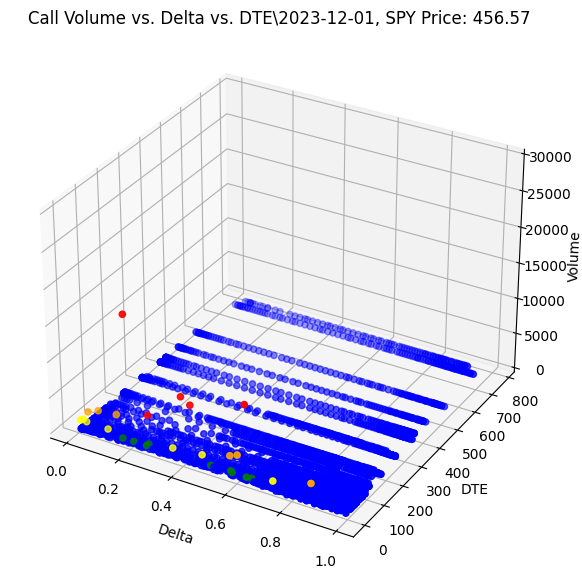

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np

# Load your DataFrame 'df'
# df = pd.read_csv('path_to_your_file.csv')

# Convert 'Timestamp' and 'Exp' to datetime, and calculate DTE
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Exp'] = pd.to_datetime(df['Exp'])
df['DTE'] = (df['Exp'] - df['Timestamp']).dt.days

# Define call volume ranges for color coding, ensuring it covers the full range statically
call_volume_ranges = [0, 500, 1000, 2000, 4000, max(df['Call Volume'].max(), 10000)]
colors = ['blue', 'green', 'yellow', 'orange', 'red']
color_labels = ['0-500', '501-1000', '1001-2000', '2001-4000', '>4000']

# Mapping call volume to color labels for the entire dataframe
df['Volume Range'] = pd.cut(df['Call Volume'], bins=call_volume_ranges, labels=color_labels, include_lowest=True)
df['Volume Color'] = df['Volume Range'].map(dict(zip(color_labels, colors)))

# Preparing the animation with a focus on static color application
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.clear()
    # Filter data for the current frame without altering color mapping
    current_timestamp = df['Timestamp'].unique()[frame]
    current_df = df[df['Timestamp'] == current_timestamp]

    # Apply colors directly, assuming 'Volume Color' is static and correctly assigned
    ax.scatter(current_df['Call Delta'], current_df['DTE'], current_df['Call Volume'], c=current_df['Volume Color'].values)
    current_timestamp_dt = pd.to_datetime(current_timestamp).to_pydatetime()
    formatted_timestamp = current_timestamp_dt.strftime('%Y-%m-%d')
    spy_price = current_df['Underlying Price'].iloc[0] if not current_df['Underlying Price'].empty else 'N/A'
    ax.set_title(f'Call Volume vs. Delta vs. DTE\{formatted_timestamp}, SPY Price: {spy_price}')
    ax.set_xlabel('Delta')
    ax.set_ylabel('DTE')
    ax.set_zlabel('Volume')
    ax.set_zlim(0,30000)

num_frames = len(df['Timestamp'].unique())

ani = FuncAnimation(fig, update, frames=num_frames, repeat=False)

# Saving the animation; ensure ffmpeg is installed
ani.save('call_volume_animation.mp4', writer='ffmpeg', fps=5)

# For inline display in Jupyter Notebooks (might not work in all environments)
from IPython.display import HTML
HTML(ani.to_html5_video())


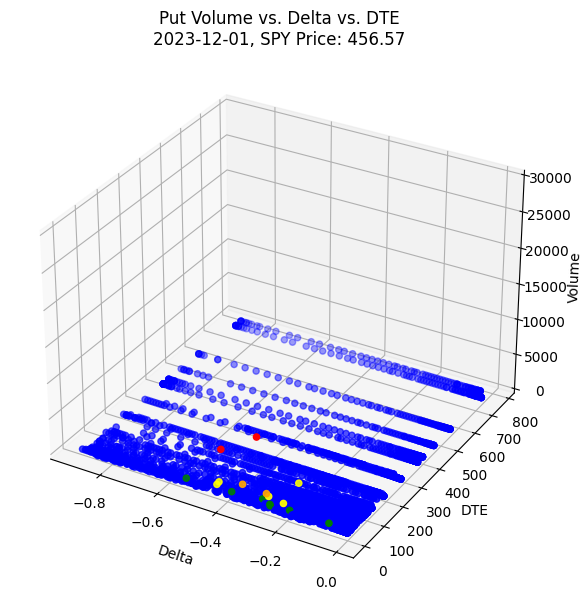

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np

# Load your DataFrame 'df'
# df = pd.read_csv('path_to_your_file.csv')

# Convert 'Timestamp' and 'Exp' to datetime, and calculate DTE
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Exp'] = pd.to_datetime(df['Exp'])
df['DTE'] = (df['Exp'] - df['Timestamp']).dt.days

# Define put volume ranges for color coding, ensuring it covers the full range statically
put_volume_ranges = [0, 500, 1000, 2000, 4000, max(df['Put Volume'].max(), 10000)]
colors = ['blue', 'green', 'yellow', 'orange', 'red']
color_labels = ['0-500', '501-1000', '1001-2000', '2001-4000', '>4000']

# Mapping put volume to color labels for the entire dataframe
df['Volume Range'] = pd.cut(df['Put Volume'], bins=put_volume_ranges, labels=color_labels, include_lowest=True)
df['Volume Color'] = df['Volume Range'].map(dict(zip(color_labels, colors)))

# Preparing the animation with a focus on static color application
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.clear()
    # Filter data for the current frame without altering color mapping
    current_timestamp = df['Timestamp'].unique()[frame]
    current_df = df[df['Timestamp'] == current_timestamp]

    # Apply colors directly, assuming 'Volume Color' is static and correctly assigned
    ax.scatter(current_df['Put Delta'], current_df['DTE'], current_df['Put Volume'], c=current_df['Volume Color'].values)
    current_timestamp_dt = pd.to_datetime(current_timestamp).to_pydatetime()
    formatted_timestamp = current_timestamp_dt.strftime('%Y-%m-%d')
    spy_price = current_df['Underlying Price'].iloc[0] if not current_df['Underlying Price'].empty else 'N/A'
    ax.set_title(f'Put Volume vs. Delta vs. DTE\n{formatted_timestamp}, SPY Price: {spy_price}')
    ax.set_xlabel('Delta')
    ax.set_ylabel('DTE')
    ax.set_zlabel('Volume')
    ax.set_zlim(0,30000)

ani = FuncAnimation(fig, update, frames=num_frames, repeat=False)

# Rest of the saving or displaying code remains the same



# Saving the animation; ensure ffmpeg is installed
ani.save('put_volume_animation.mp4', writer='ffmpeg', fps=5)

# For inline display in Jupyter Notebooks (might not work in all environments)
from IPython.display import HTML
HTML(ani.to_html5_video())
